In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
from scipy import integrate

import matplotlib.pyplot as plt
import matplotlib.ticker

import os
import sys

In [4]:
sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot
import akta

import my_functions as my_fun

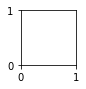

In [5]:
fig, ax = my_plot.instantiate_fig(1, 1)

# Data extraction
## Recover the original data

Only needs to be performed once

In [5]:
# folder = './data/raw_summary_files/'
# files  = os.listdir(folder)
# files.remove('2019-06-02 Beta-lactoglobulin pH 7 - Rep 2.xlsx')
# files.sort()

# proteins = { '2019-06-02 Beta-lactoglobulin pH 7 - Rep 1.xlsx':'blg',
#              '2019-06-02 Beta-lactoglobulin pH 7 - Rep 2 - redundant removed.xlsx':'blg',
#              '2019-06-03 Catalase pH 7.xlsx':'cat',
#              '2019-06-19 Ovalbumin pH 7.xlsx':'ova',
#              '2019-06-27 Alcohol Dehydrogenase pH 7.xlsx':'adh'}

# for f in files:
#     protein = proteins[f]
#     data = pd.ExcelFile(folder + f)
#     tabs = data.sheet_names
    
#     for t in [t for t in tabs if 'mM' in t]:
#         strings = [s for s in t.split()]

#         vals = [n for n in strings if n.replace('.', '', 1).isdigit()]
#         assert len(vals) == 1
#         nacl = vals[0]

#         resin = strings[0]
#         if resin == 'CQ':
#             resin = 'caq'
#         else:
#             resin = resin.lower()

#         if 'Rep 2' in f or '(2)' in strings:
#             rep = 2
#         else:
#             rep = 1
            
#         name = f'{protein}_{resin}_{nacl}_rep_{rep}'
        
#         df_dirty = data.parse(t)
#         df = df_dirty[['Time (min)', 'Absorbance (mAU)']]
#         df.to_csv(f'./data/split_files/{name}', index=False)

## Check data recovery and rename columns

Only needs to be performed once

In [6]:
# folder = './data/split_files/'
# files  = os.listdir(folder)
# files.sort()

# for f in files:
#     df = pd.read_csv(folder + f)
#     assert 'Time (min)' in df.columns and 'Absorbance (mAU)' in df.columns
#     assert len(df) > 50
#     df.rename(columns={'Time (min)':'time_min', 'Absorbance (mAU)':'absorb_mau'}, inplace=True)
#     df.to_csv(folder + f, index=False)
    
# for f in files:
#     df = pd.read_csv(folder + f)
#     assert 'time_min' in df.columns and 'absorb_mau' in df.columns

# First cleaning of data

The following occurs when the (split) raw data files are loaded:
- Time is converted to volume and column volume
- The first absorbance measurement is used to zero the profile
- A linear baseline drift correction is applied
- The first moment is estimated (and the extra-column volume is subtracted)

In [228]:
folder = './data/split_files/'
files  = os.listdir(folder)
files.sort()

data_files = {}
for f in files:
    data_files[f] = my_fun.run_data(folder, f)

## Demonstrate baseline correction
### Low salt

In [5]:
df = data_files['blg_caq_175_rep_1'].df

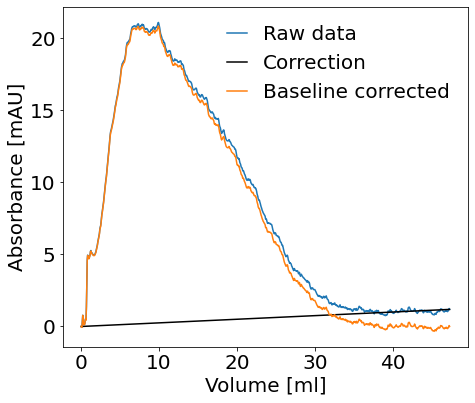

In [7]:
fig, ax = my_plot.instantiate_fig()
ax.set_xlabel('Volume [ml]')
ax.set_ylabel('Absorbance [mAU]')

x = df.vol_ml.values
y = df.absorb_mau.values
ax.plot(x, y, label='Raw data')
ax.plot([x[0], x[-1]], [y[0], y[-1]], color='black', label='Correction')

ax.plot(df.vol_ml, df.absorb_corrected, label='Baseline corrected')

my_plot.set_layout(fig, ax, legend=True)
# fig.savefig('./images/baseline_drift_demo_denominator_low_salt.png', dpi=300)

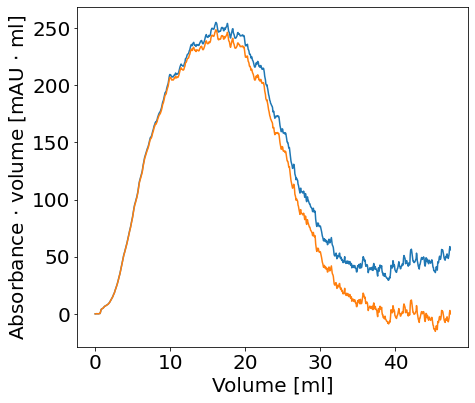

In [289]:
fig, ax = my_plot.instantiate_fig()
ax.set_xlabel('Volume [ml]')
ax.set_ylabel(r'Absorbance $\cdot$ volume [mAU $\cdot$ ml]')

ax.plot(df.vol_ml, df.absorb_mau*df.vol_ml)
ax.plot(df.vol_ml, df.absorb_corrected*df.vol_ml)

my_plot.set_layout(fig, ax)
# fig.savefig('./images/baseline_drift_demo_numerator_low_salt.png', dpi=300)

In [290]:
num_cor = integrate.simps(df.absorb_corrected*df.vol_ml, df.vol_ml)
num_raw = integrate.simps(df.absorb_mau*df.vol_ml, df.vol_ml)
den_cor = integrate.simps(df.absorb_corrected, df.vol_ml)
den_raw = integrate.simps(df.absorb_mau, df.vol_ml)

moment_cor = akta.get_first_moment(df.vol_ml, df.absorb_corrected)
moment_raw = akta.get_first_moment(df.vol_ml, df.absorb_mau)

assert num_cor/den_cor - moment_cor == 0.0
assert num_raw/den_raw - moment_raw == 0.0

print(f' Raw denominator = {den_raw:.2f} mAU ml \n Cor denominator = {den_cor:.2f} mAU ml \n')
print(f' Raw numerator = {num_raw:.2f} mAU ml2 \n Cor numerator = {num_cor:.2f} mAU ml2 \n')
print(f' Raw moment = {moment_raw:.2f} ml \n Cor moment = {moment_cor:.2f} ml \n')

 Raw denominator = 391.93 mAU ml 
 Cor denominator = 363.90 mAU ml 

 Raw numerator = 5636.33 mAU ml2 
 Cor numerator = 4752.55 mAU ml2 

 Raw moment = 14.38 ml 
 Cor moment = 13.06 ml 



### High salt

In [291]:
df = data_files['blg_caq_956_rep_1'].df

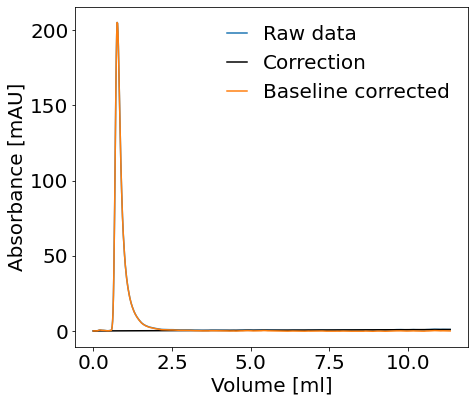

In [292]:
fig, ax = my_plot.instantiate_fig()
ax.set_xlabel('Volume [ml]')
ax.set_ylabel('Absorbance [mAU]')

x = df.vol_ml.values
y = df.absorb_mau.values
ax.plot(x, y, label='Raw data')
ax.plot([x[0], x[-1]], [y[0], y[-1]], color='black', label='Correction')

ax.plot(df.vol_ml, df.absorb_corrected, label='Baseline corrected')

my_plot.set_layout(fig, ax, legend=True)
# fig.savefig('./images/baseline_drift_demo_denominator_high_salt.png', dpi=300)

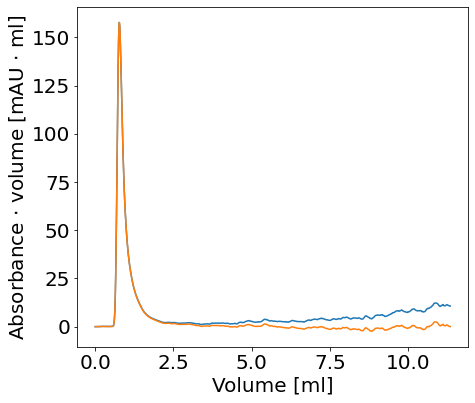

In [293]:
fig, ax = my_plot.instantiate_fig()
ax.set_xlabel('Volume [ml]')
ax.set_ylabel(r'Absorbance $\cdot$ volume [mAU $\cdot$ ml]')

ax.plot(df.vol_ml, df.absorb_mau*df.vol_ml)
ax.plot(df.vol_ml, df.absorb_corrected*df.vol_ml)

my_plot.set_layout(fig, ax)
# fig.savefig('./images/baseline_drift_demo_numerator_high_salt.png', dpi=300)

In [294]:
num_cor = integrate.simps(df.absorb_corrected*df.vol_ml, df.vol_ml)
num_raw = integrate.simps(df.absorb_mau*df.vol_ml, df.vol_ml)
den_cor = integrate.simps(df.absorb_corrected, df.vol_ml)
den_raw = integrate.simps(df.absorb_mau, df.vol_ml)

moment_cor = akta.get_first_moment(df.vol_ml, df.absorb_corrected)
moment_raw = akta.get_first_moment(df.vol_ml, df.absorb_mau)

assert num_cor/den_cor - moment_cor == 0.0
assert num_raw/den_raw - moment_raw == 0.0

print(f' Raw denominator = {den_raw:.2f} mAU ml \n Cor denominator = {den_cor:.2f} mAU ml \n')
print(f' Raw numerator = {num_raw:.2f} mAU ml2 \n Cor numerator = {num_cor:.2f} mAU ml2 \n')
print(f' Raw moment = {moment_raw:.2f} ml \n Cor moment = {moment_cor:.2f} ml \n')

 Raw denominator = 60.51 mAU ml 
 Cor denominator = 55.16 mAU ml 

 Raw numerator = 88.80 mAU ml2 
 Cor numerator = 48.41 mAU ml2 

 Raw moment = 1.47 ml 
 Cor moment = 0.88 ml 



# Inspect the data
## Create reference maps

In [229]:
## For reference 
proteins = ['adh', 'blg', 'cat', 'ova']
resins   = ['caq', 'phq', 'pxq']

# Name maps
protein_name =\
{'adh':'Alcohol dehydrogenase',
 'blg':r'$\beta$-lactoglobulin',
 'cat':'Catalase',
 'ova':'Ovalbumin' 
}

resin_name =\
{'caq':'Capto Q',
 'phq':'Poros 50 HQ',
 'pxq':'Poros XQ',
}

# Enumeration maps
potein_number = {}
for i, pro in enumerate(proteins):
    potein_number[pro] = i
    
resin_number = {}
for i, res in enumerate(resins):
    resin_number[res] = i

# Map of NaCl concentrations used with each protein-resin pair
nacl_used = {}
for pro in proteins:
    for res in resins:
        nacl_used[(pro, res)] = []
for f in files:
    data = data_files[f]
    current_list = nacl_used[(data.protein, data.resin)]
    if data.nacl not in current_list:
        nacl_used[(data.protein, data.resin)].append(data.nacl)
        nacl_used[(data.protein, data.resin)].sort()

## Draw plots

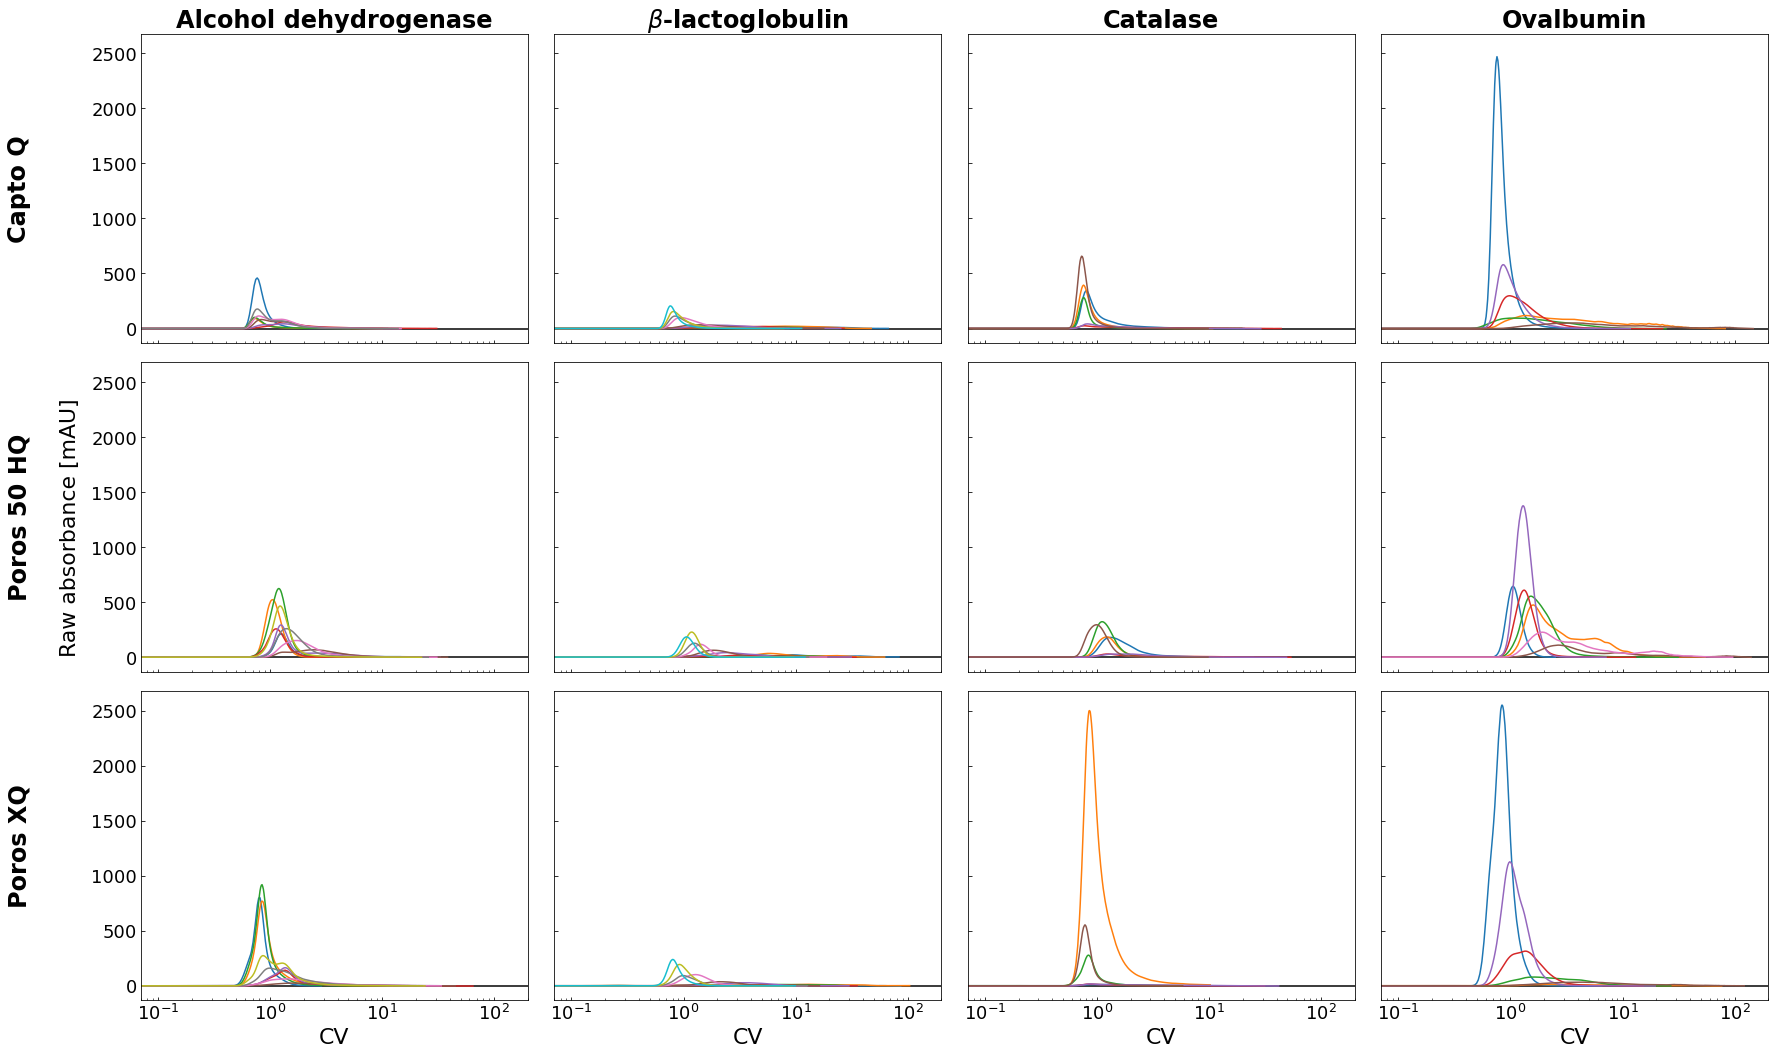

In [175]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
        ax[n_res, n_pro].axhline(color='black')
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, 'Raw absorbance [mAU]', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for f in files:
    data = data_files[f]
    if data.replicate == 1:
        n_pro = potein_number[data.protein]
        n_res = resin_number[data.resin]
        ax[n_res, n_pro].plot(data.df.cv, data.df.absorb_mau)

# Set axis scales
ax[0, 0].set_xlim(0.07, 200)
ax[0, 0].set_xscale('log')

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
# fig.savefig('./images/chromatograms_raw_rep_1_sharey.png', dpi=300)

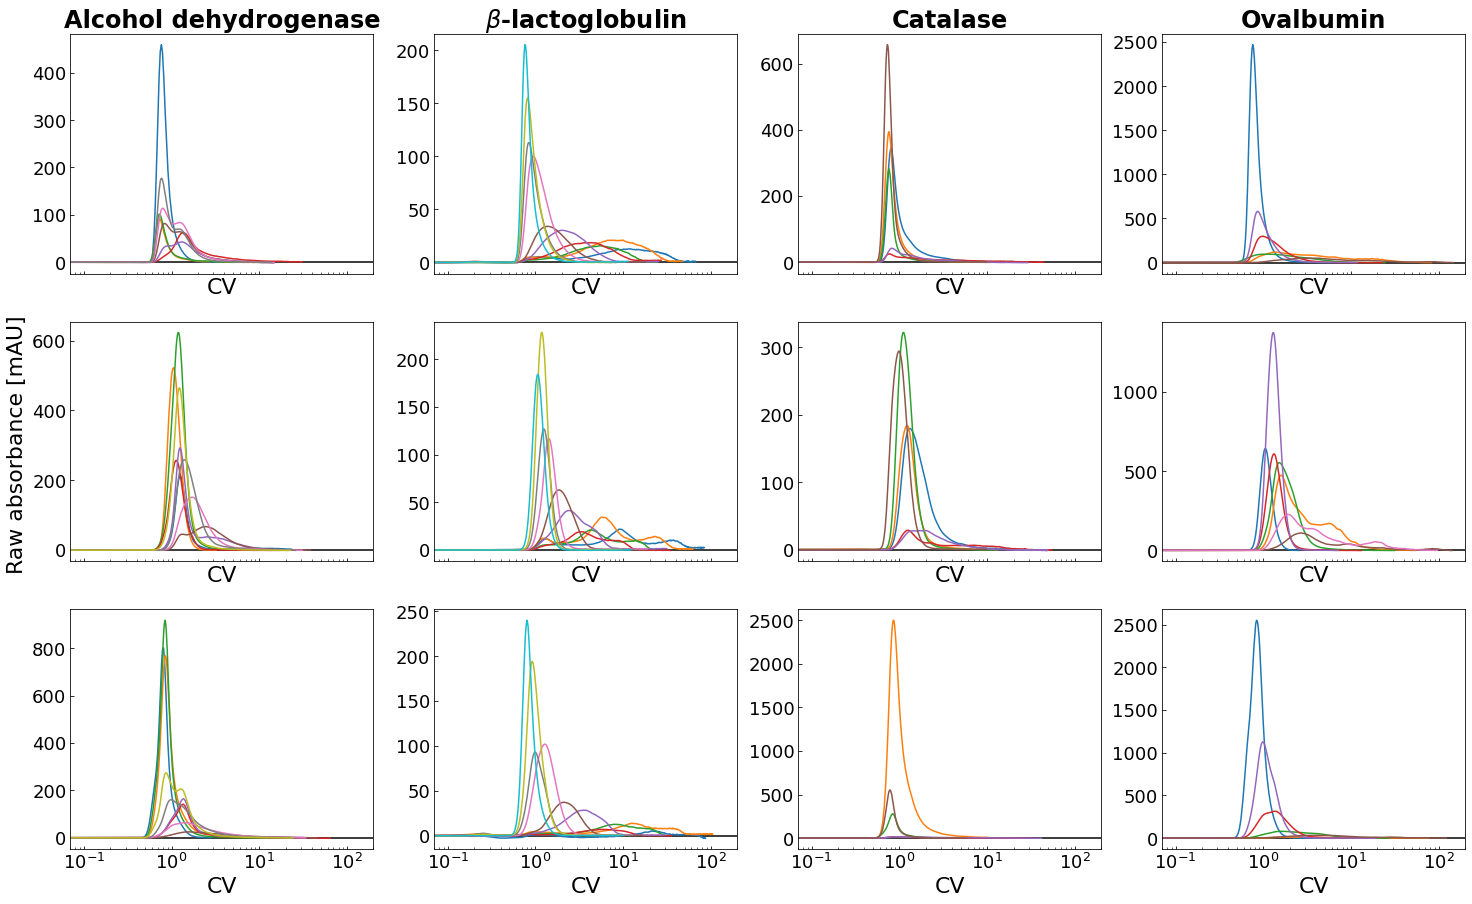

In [189]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV', fontsize=label_size)
        ax[n_res, n_pro].axhline(color='black')
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.09, 0.5, 'Raw absorbance [mAU]', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for f in files:
    data = data_files[f]
    if data.replicate == 1:
        n_pro = potein_number[data.protein]
        n_res = resin_number[data.resin]
        ax[n_res, n_pro].plot(data.df.cv, data.df.absorb_mau)

# Set axis scales
ax[0, 0].set_xlim(0.07, 200)
ax[0, 0].set_xscale('log')

# Format and save the figure
fig.patch.set_alpha(1)
# fig.savefig('./images/chromatograms_raw_rep_1.png', dpi=300)

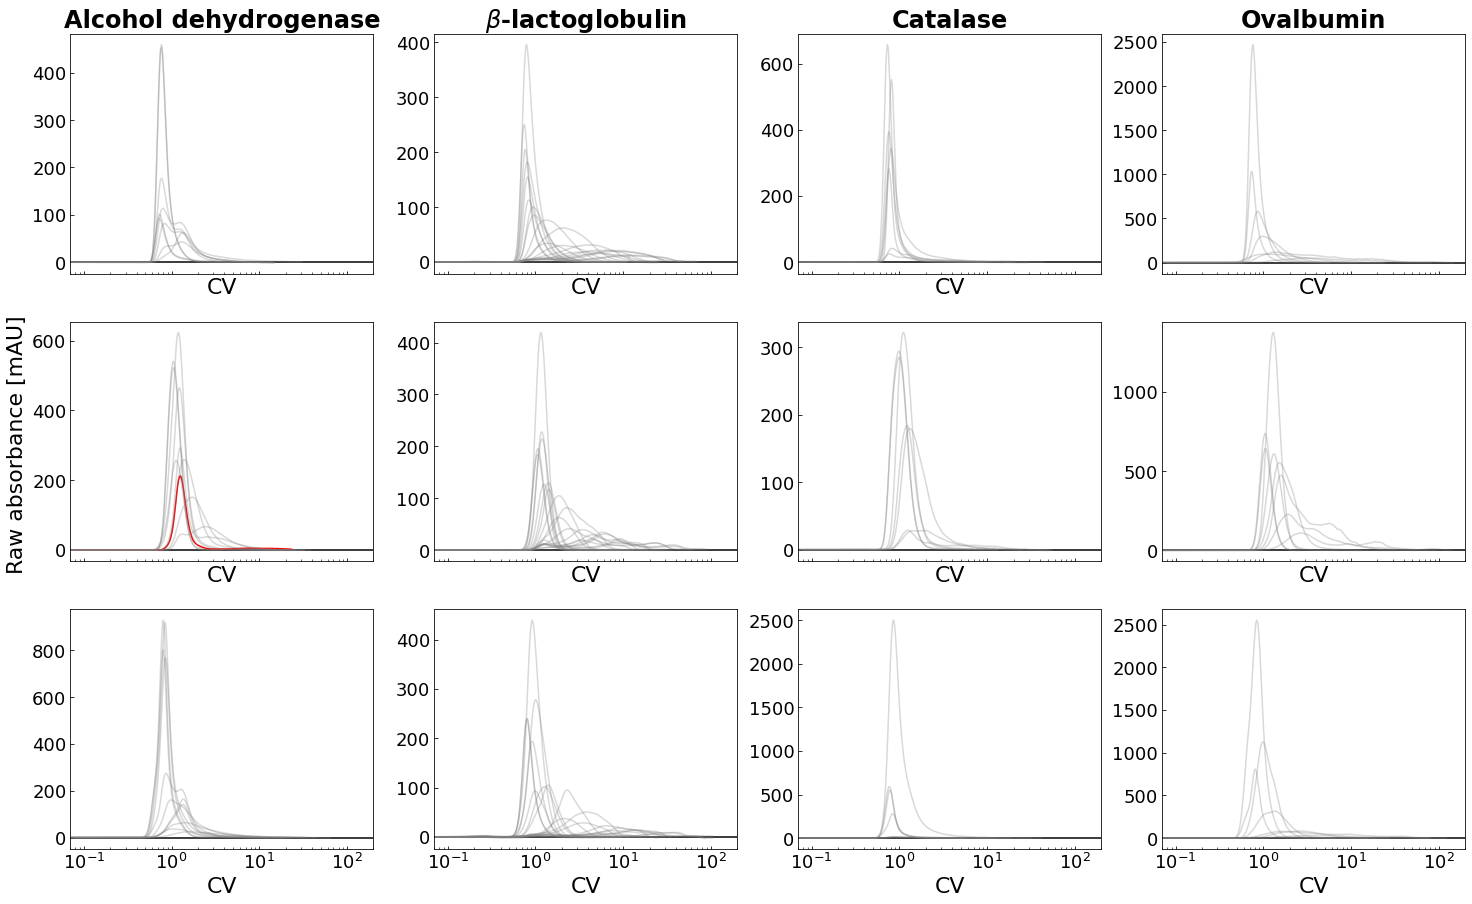

In [191]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV', fontsize=label_size)
        ax[n_res, n_pro].axhline(color='black')
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.09, 0.5, 'Raw absorbance [mAU]', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for i, f in enumerate(files):
    data = data_files[f]
    n_pro = potein_number[data.protein]
    n_res = resin_number[data.resin]
    if data.nacl == 0.0:
        ax[n_res, n_pro].plot(data.df.cv, data.df.absorb_mau, color='red')
    else:
        ax[n_res, n_pro].plot(data.df.cv, data.df.absorb_mau, color='grey', alpha=0.3)

# Set axis scales
ax[0, 0].set_xlim(0.07, 200)
ax[0, 0].set_xscale('log')

# Format and save the figure
fig.patch.set_alpha(1)
# fig.savefig('./images/chromatograms_raw_rep_1_no_salt_control_highlighted.png', dpi=300)

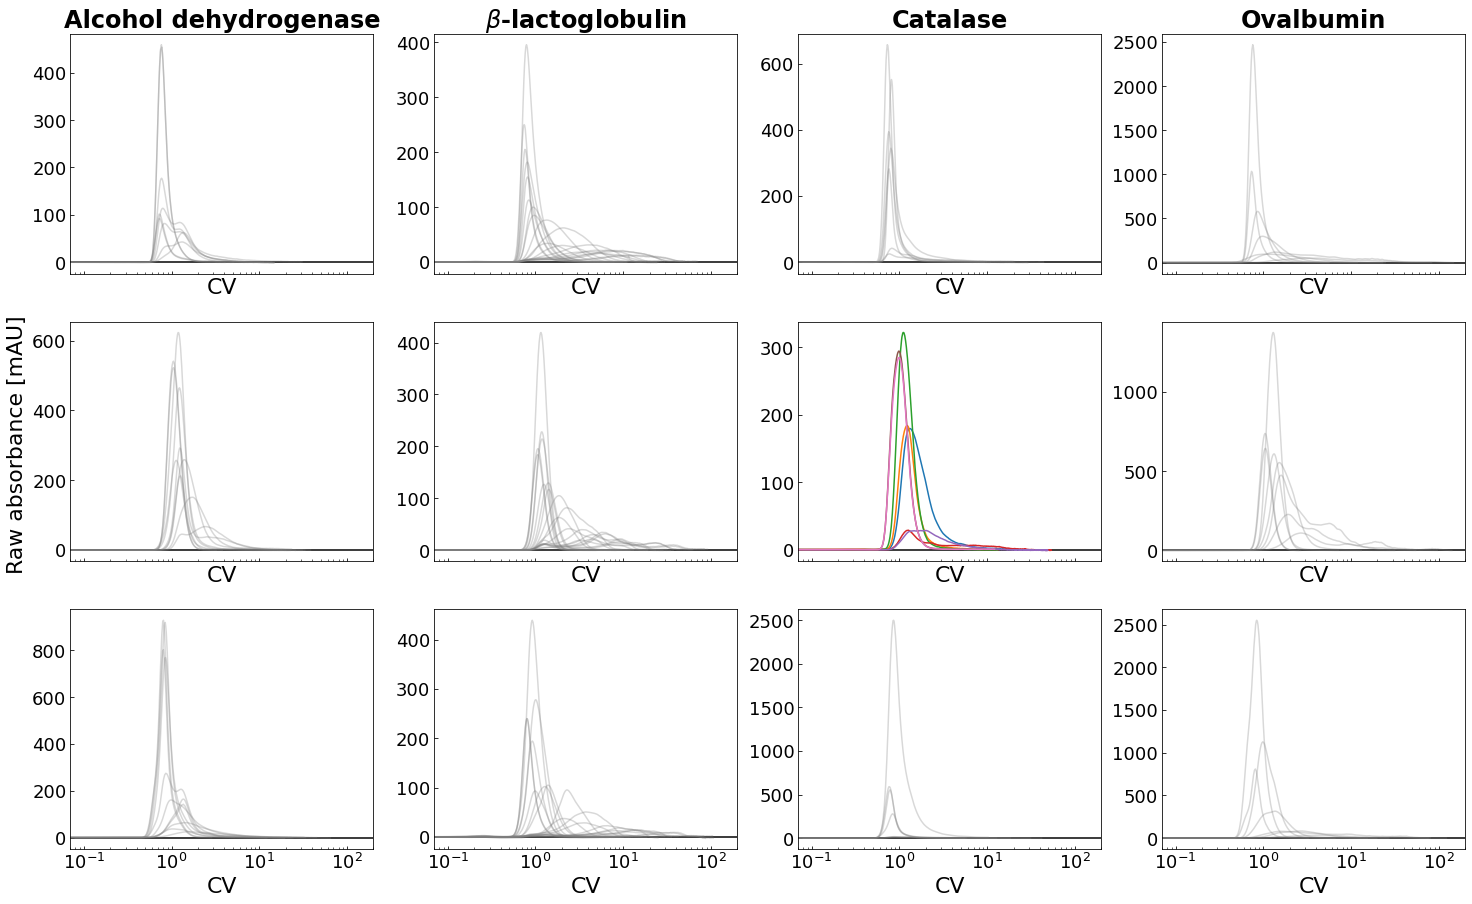

In [231]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV', fontsize=label_size)
        ax[n_res, n_pro].axhline(color='black')
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.09, 0.5, 'Raw absorbance [mAU]', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for i, f in enumerate(files):
    data = data_files[f]
    n_pro = potein_number[data.protein]
    n_res = resin_number[data.resin]
    if data.protein == 'cat' and data.resin=='phq':
        ax[n_res, n_pro].plot(data.df.cv, data.df.absorb_mau)
    else:
        ax[n_res, n_pro].plot(data.df.cv, data.df.absorb_mau, color='grey', alpha=0.3)

# Set axis scales
ax[0, 0].set_xlim(0.07, 200)
ax[0, 0].set_xscale('log')

# Format and save the figure
fig.patch.set_alpha(1)
fig.savefig('./images/chromatograms_raw_rep_1_problem_demo.png', dpi=300)

Reference the problem_demo notebook

Reference the baseline correction demonstration above

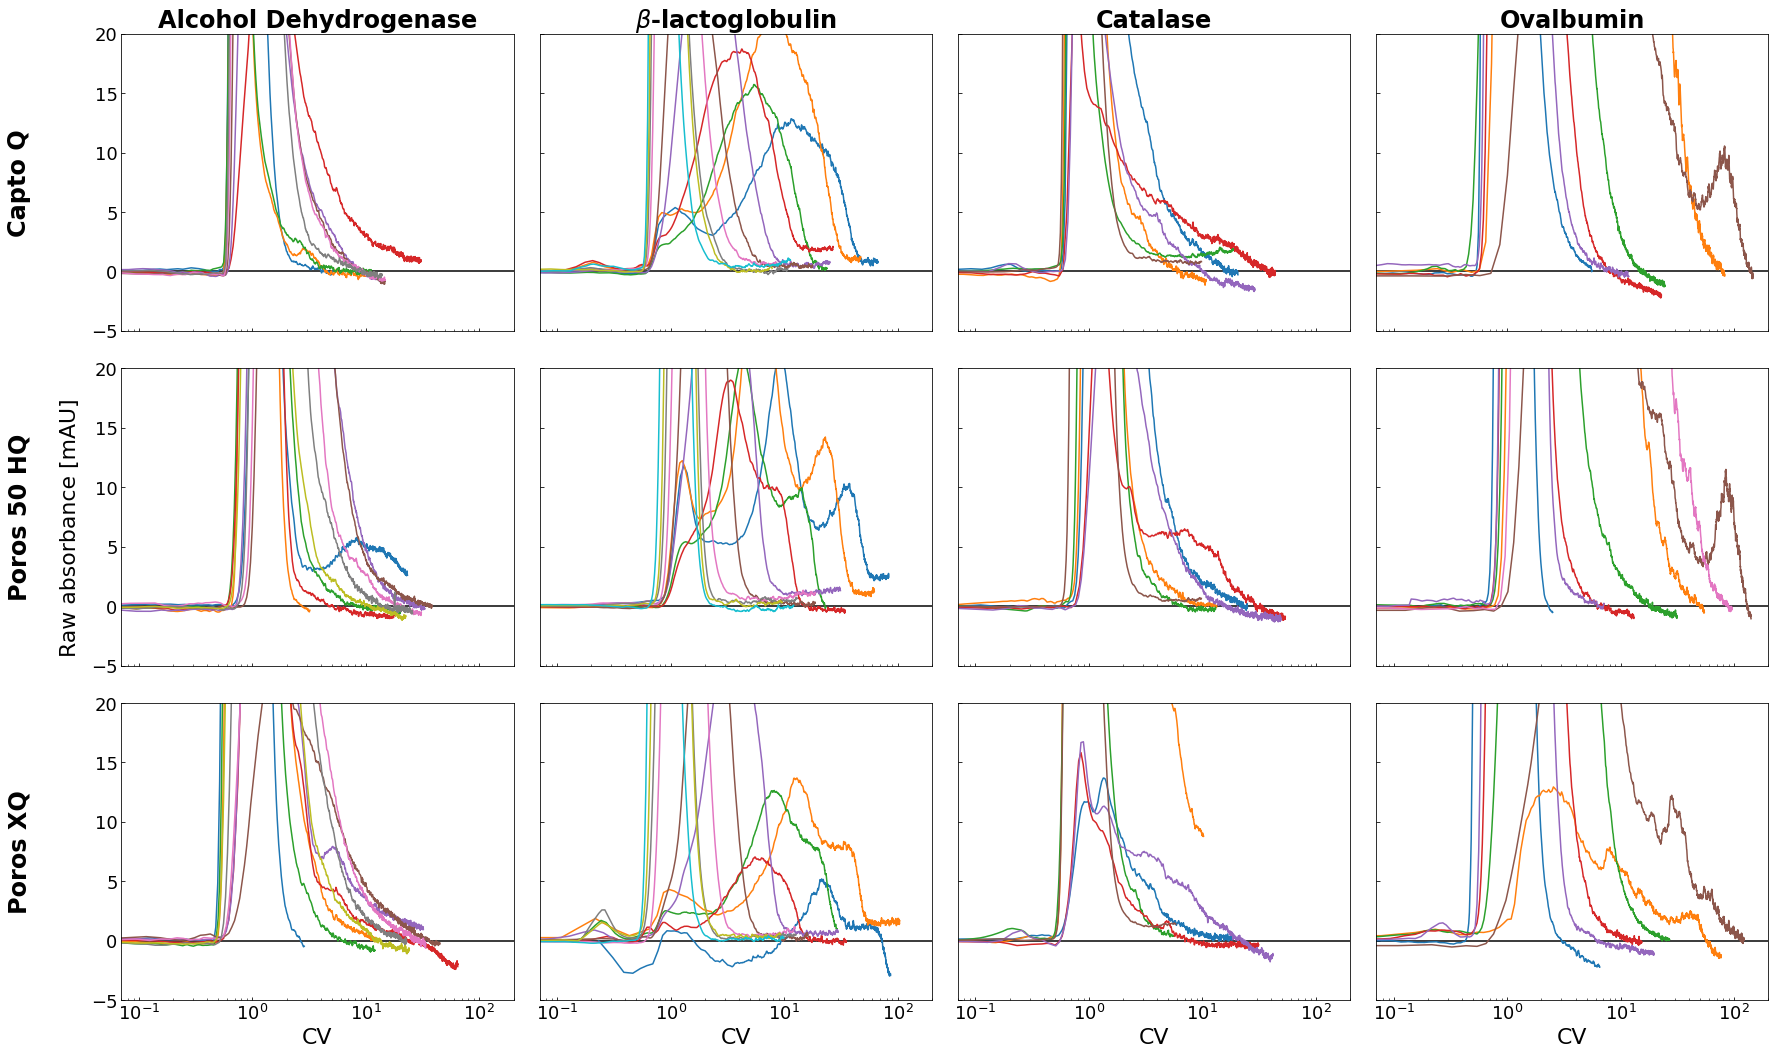

In [17]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
        ax[n_res, n_pro].axhline(color='black')
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, 'Raw absorbance [mAU]', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for f in files:
    data = data_files[f]
    if data.replicate == 1:
        n_pro = potein_number[data.protein]
        n_res = resin_number[data.resin]
        ax[n_res, n_pro].plot(data.df.cv, data.df.absorb_mau)

# Set axis scales
ax[0, 0].set_ylim(-5, 20)
ax[0, 0].set_xlim(0.07, 200)
ax[0, 0].set_xscale('log')

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
# fig.savefig('./images/chromatograms_raw_rep_1_zoomed.png', dpi=300)

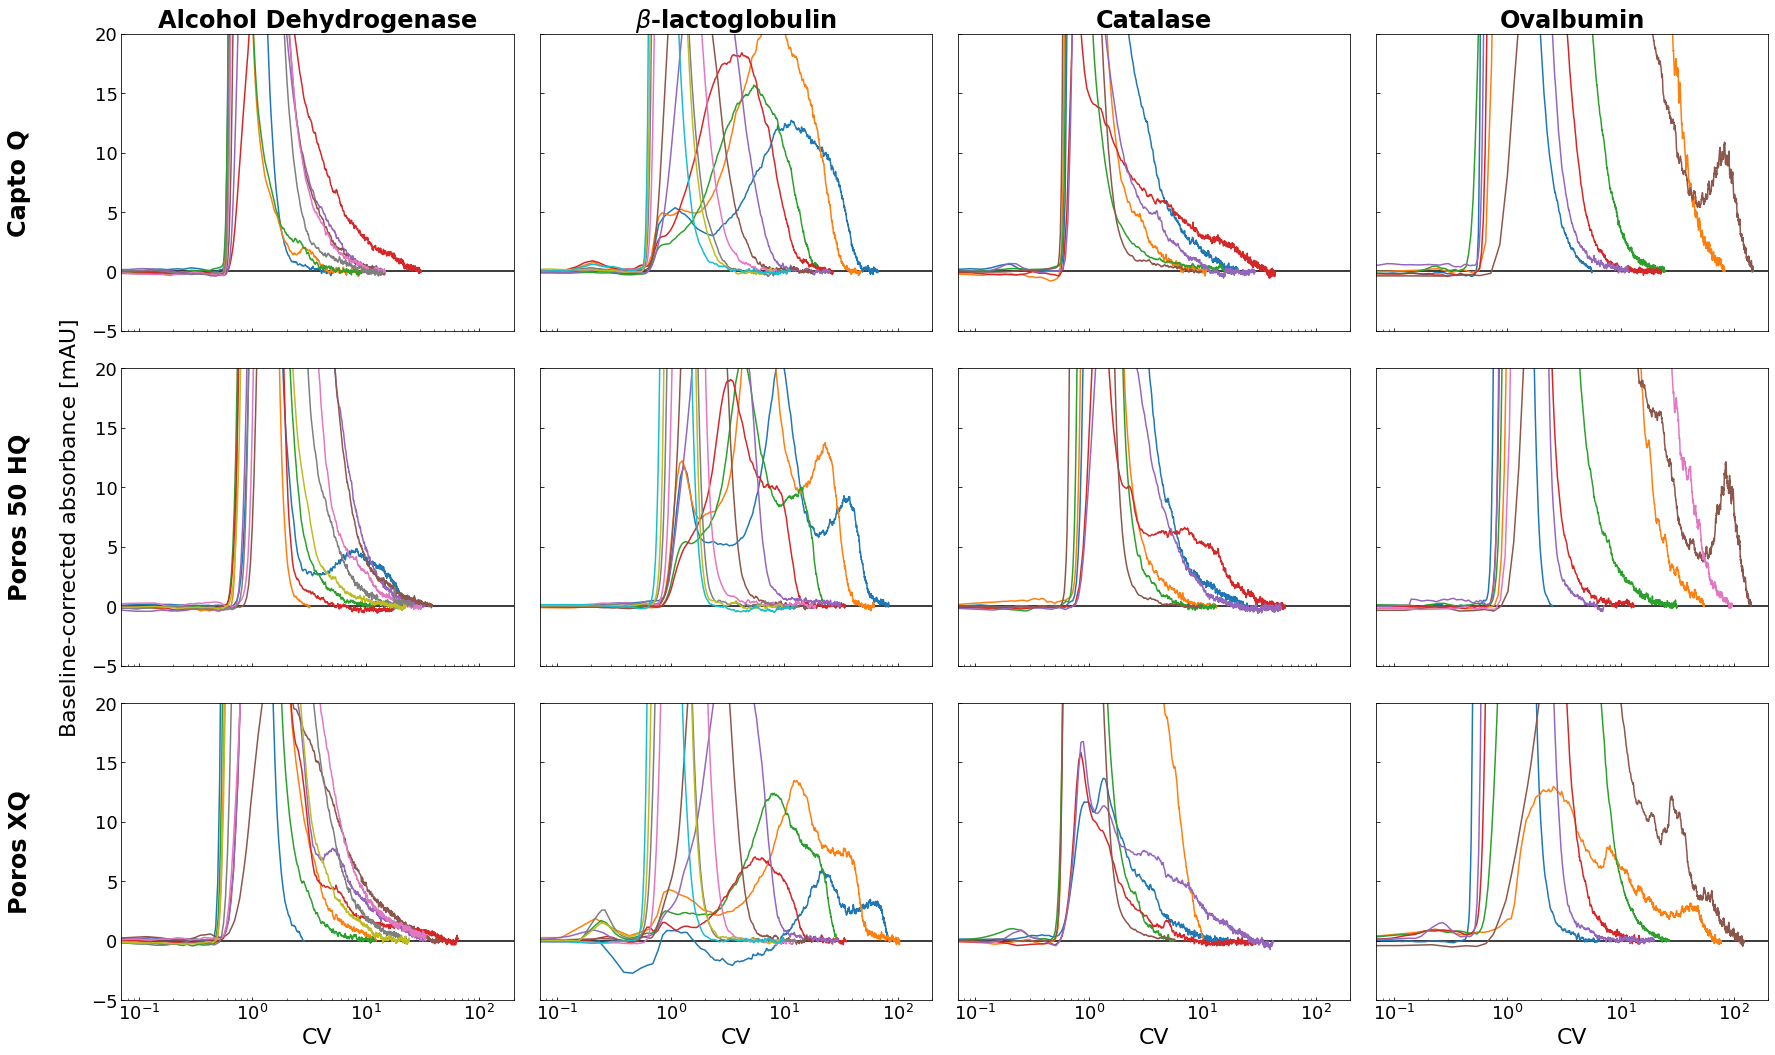

In [18]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
        ax[n_res, n_pro].axhline(color='black')
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, 'Baseline-corrected absorbance [mAU]', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for f in files:
    data = data_files[f]
    if data.replicate == 1:
        n_pro = potein_number[data.protein]
        n_res = resin_number[data.resin]
        ax[n_res, n_pro].plot(data.df.cv, data.df.absorb_corrected)

# Set axis scales
ax[0, 0].set_ylim(-5, 20)
ax[0, 0].set_xlim(0.07, 200)
ax[0, 0].set_xscale('log')

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
# fig.savefig('./images/chromatograms_baseline_corrected_rep_1_zoomed.png', dpi=300)

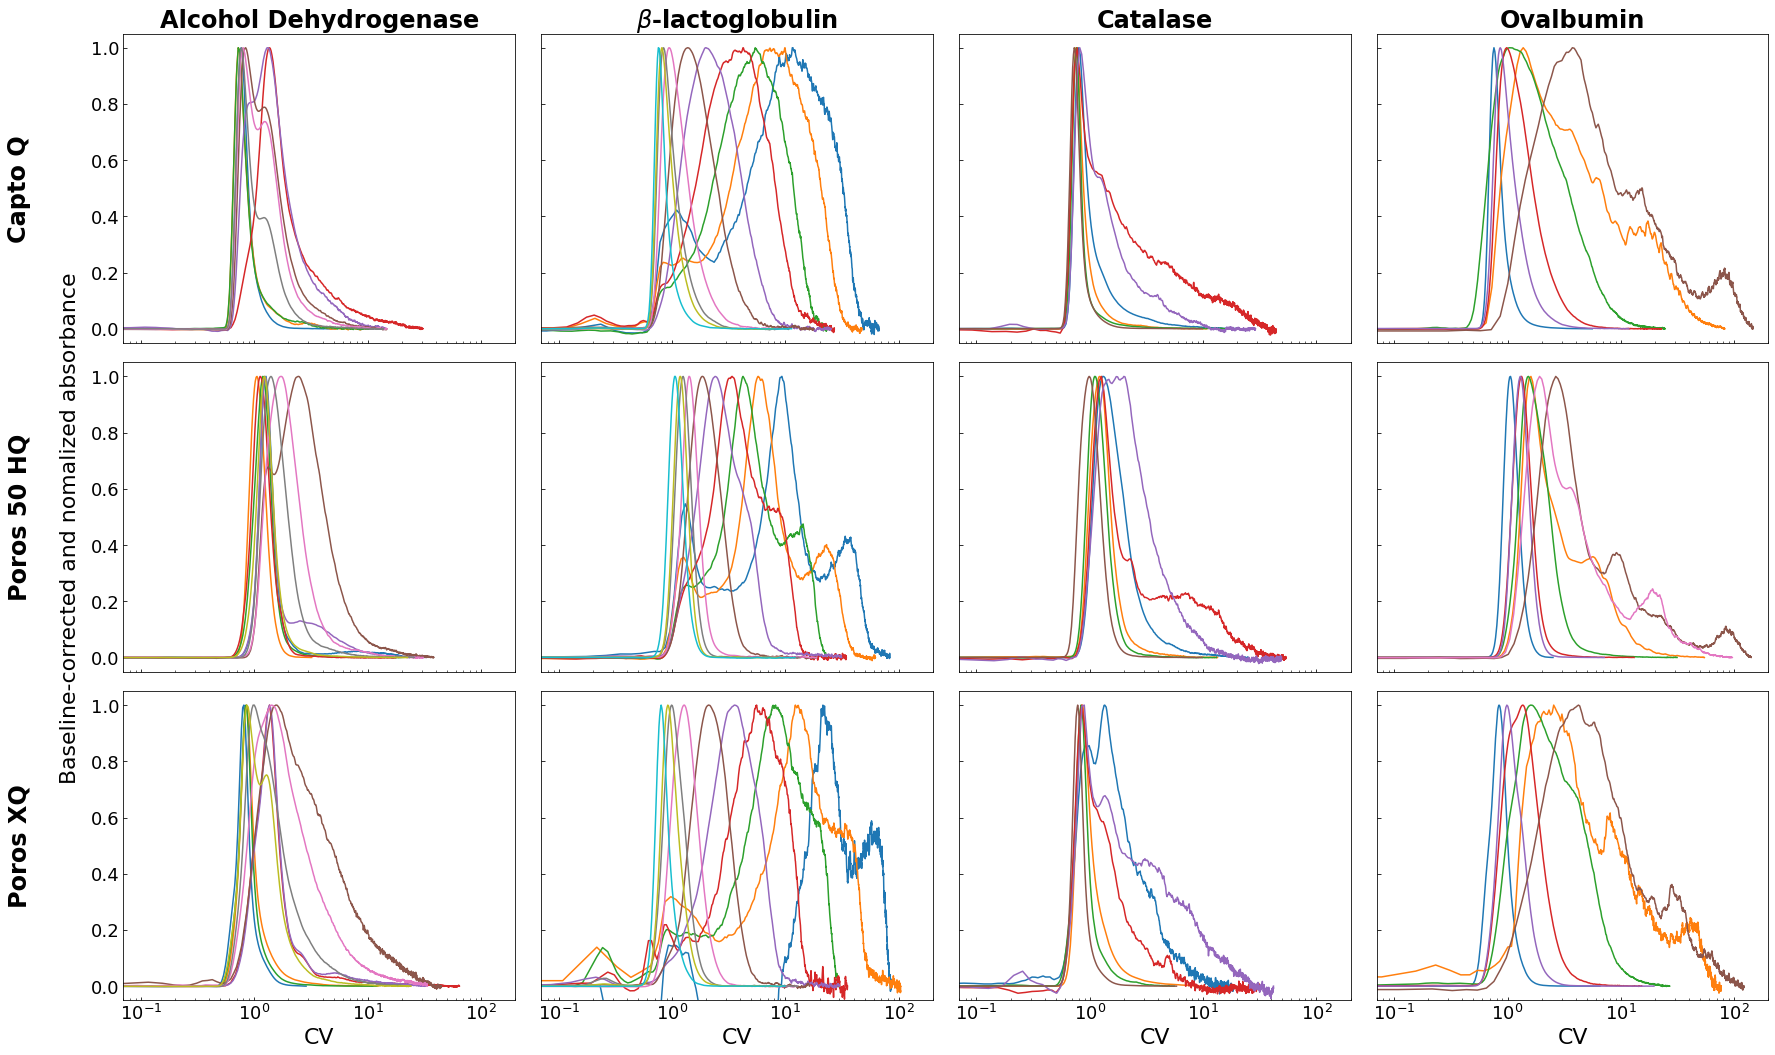

In [19]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, 'Baseline-corrected and nomalized absorbance', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for f in files:
    data = data_files[f]
    if data.replicate == 1:
        n_pro = potein_number[data.protein]
        n_res = resin_number[data.resin]
        ax[n_res, n_pro].plot(data.df.cv, data.df.absorb_corrected/data.df.absorb_corrected.max())

# Set axis scales
ax[0, 0].set_ylim(-0.05, 1.05)
ax[0, 0].set_xlim(0.07, 200)
ax[0, 0].set_xscale('log')

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
# fig.savefig('./images/chromatograms_normalized_baseline_corrected_rep_1.png', dpi=300)

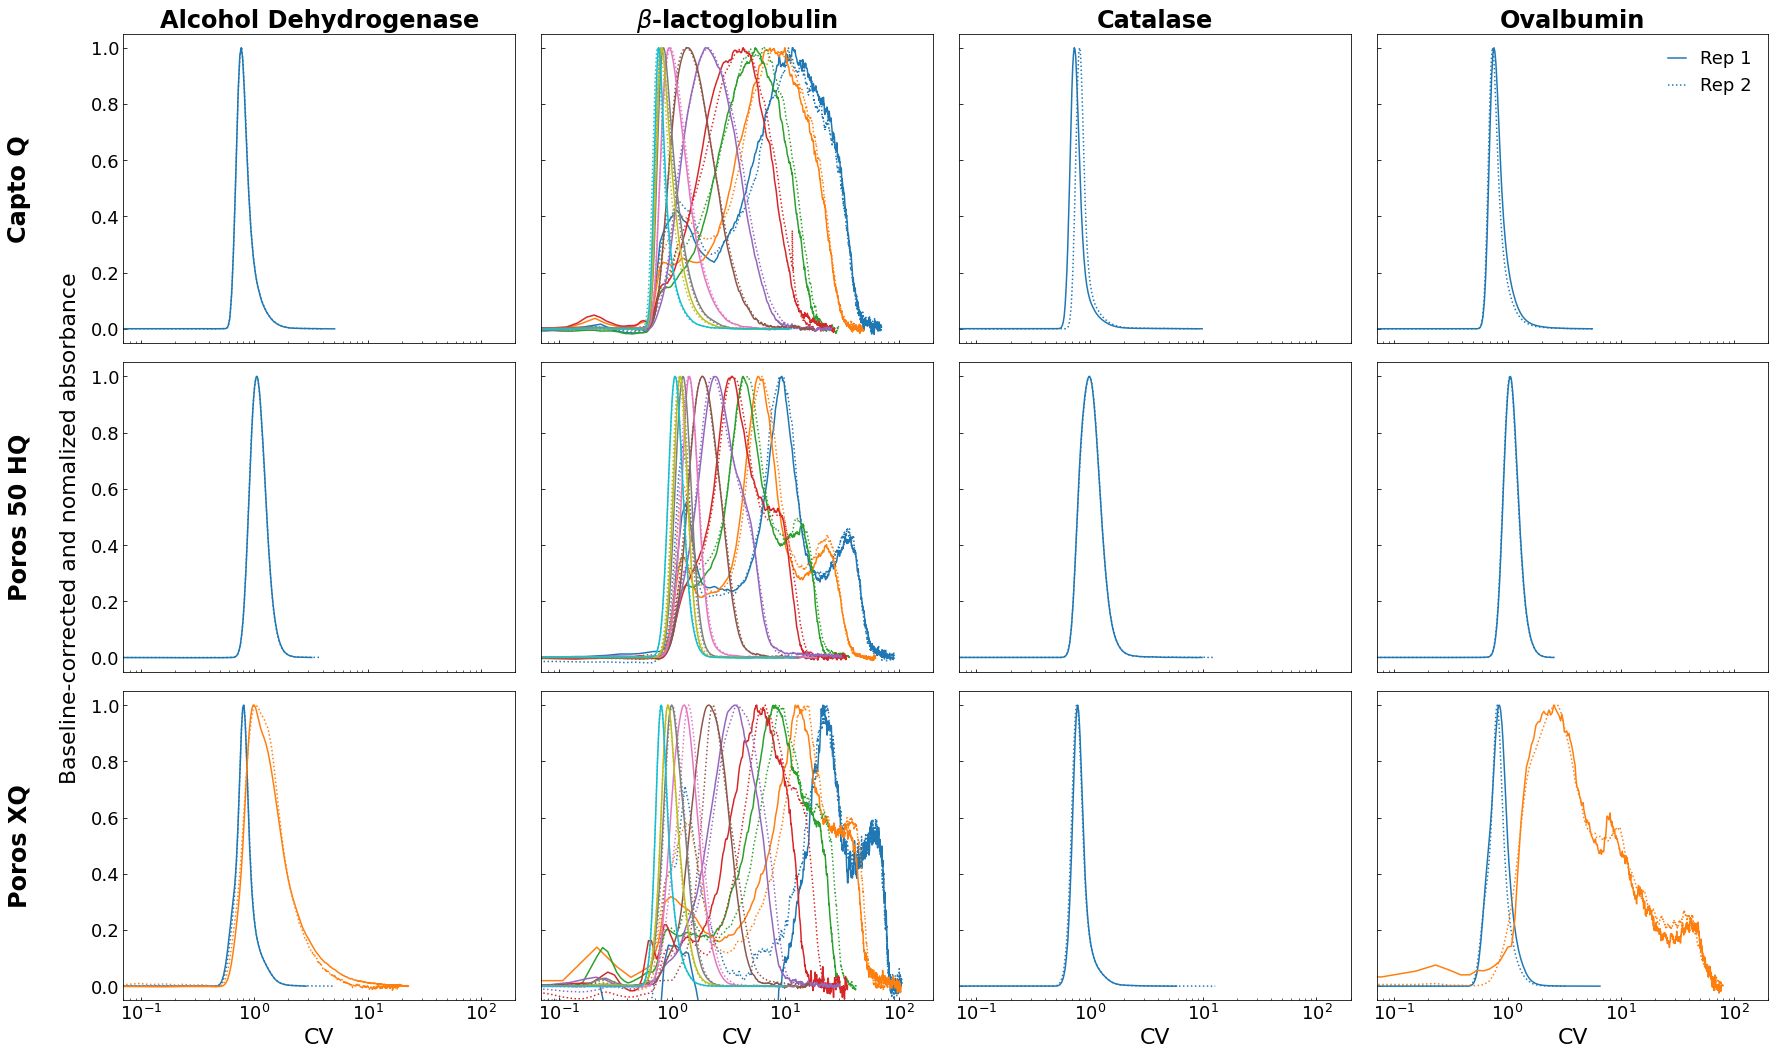

In [11]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, 'Baseline-corrected and nomalized absorbance', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for i1, f1 in enumerate(files):
    data_1 = data_files[f1]
    
    for f2 in files[i1+1:]:
        data_2 = data_files[f2]
        
        if data_1.protein == data_2.protein and data_1.resin == data_2.resin and data_1.nacl == data_2.nacl:
            n_pro = potein_number[data_1.protein]
            n_res = resin_number[data_1.resin]
            ax[n_res, n_pro].plot(data_1.df.cv, data_1.df.absorb_corrected/data_1.df.absorb_corrected.max(),
                                  label='Rep 1')
            ax[n_res, n_pro].plot(data_2.df.cv, data_2.df.absorb_corrected/data_2.df.absorb_corrected.max(), ':', 
                                  color=ax[n_res, n_pro].get_lines()[-1].get_color(), label='Rep 2')

# Set axis scales
ax[0, 0].set_ylim(-0.05, 1.05)
ax[0, 0].set_xlim(0.07, 200)
ax[0, 0].set_xscale('log')

ax[0, 3].legend(loc='best', handlelength=1, frameon=False)

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
# fig.savefig('./images/chromatograms_normalized_baseline_corrected_replicate_comparison.png', dpi=300)

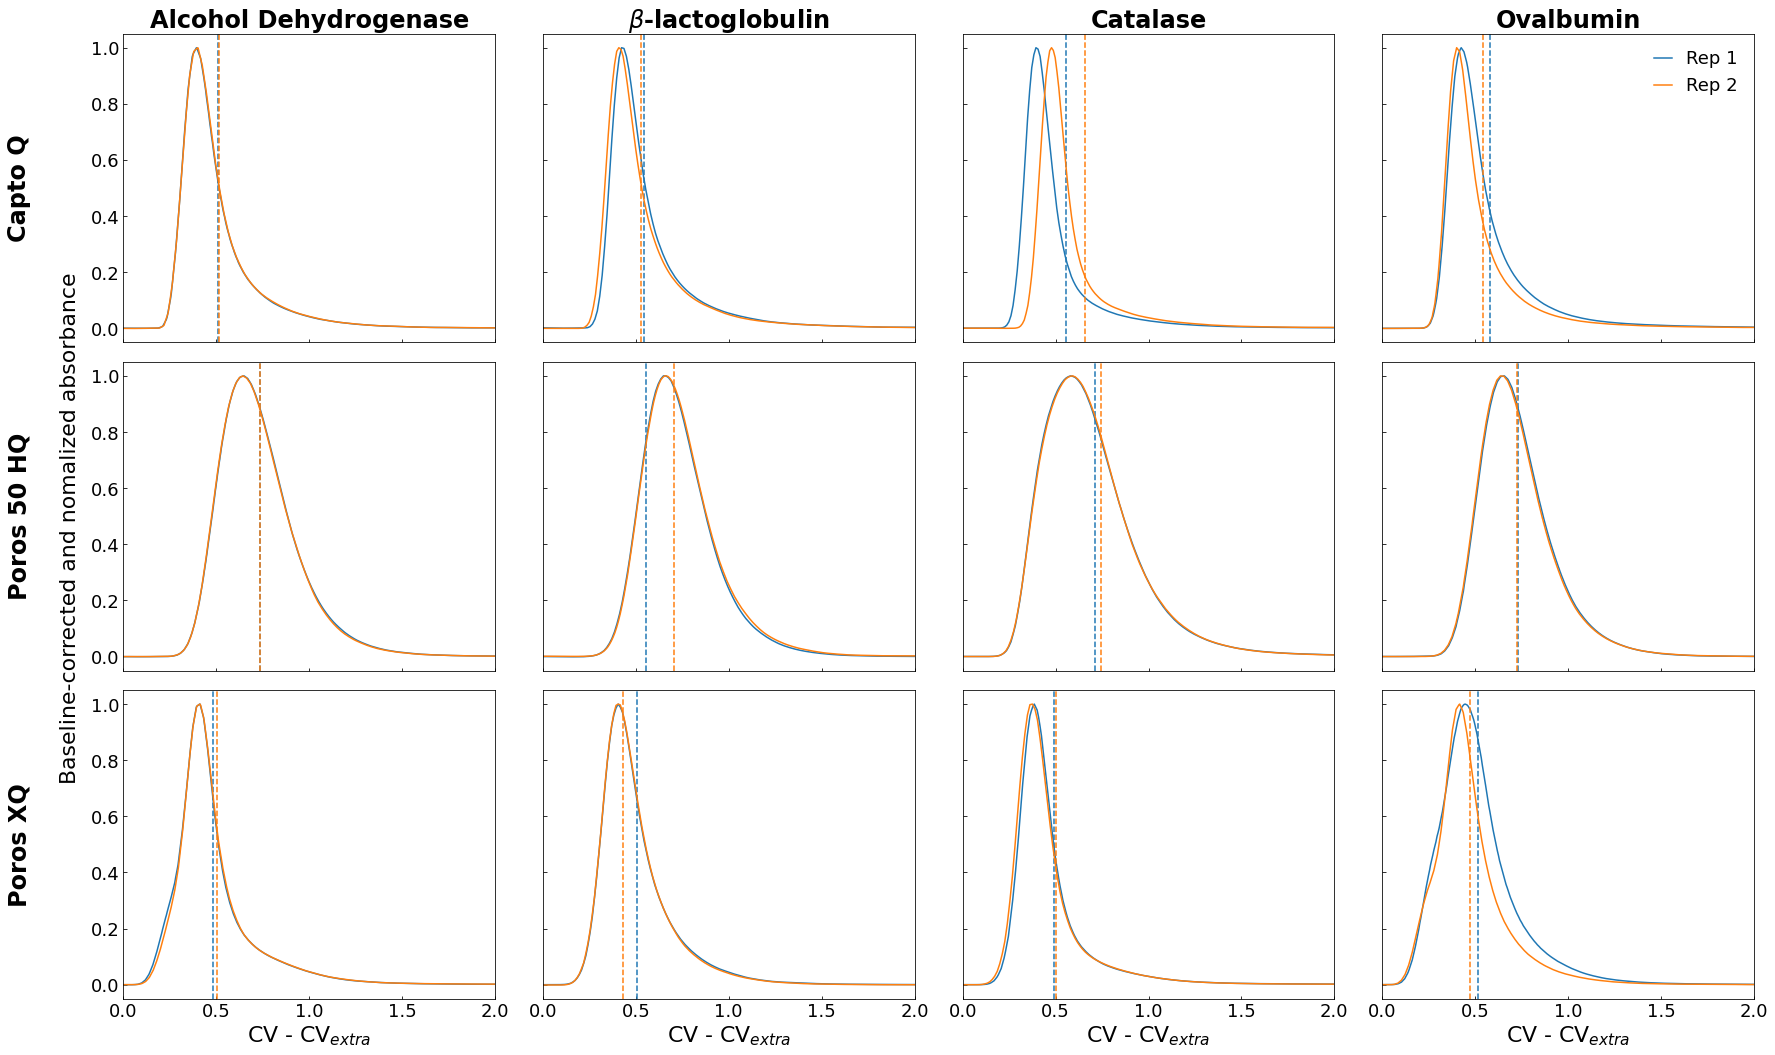

In [44]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV - CV$_{extra}$', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, 'Baseline-corrected and nomalized absorbance', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for i1, f1 in enumerate(files):
    data_1 = data_files[f1]
    
    for f2 in files[i1+1:]:
        data_2 = data_files[f2]
        
        if data_1.protein == data_2.protein and data_1.resin == data_2.resin and data_1.nacl == data_2.nacl and data_1.nacl > 900:
            n_pro = potein_number[data_1.protein]
            n_res = resin_number[data_1.resin]
            ax[n_res, n_pro].plot(data_1.df.cv - data_1.column.cv_extra, data_1.df.absorb_corrected/data_1.df.absorb_corrected.max(), label='Rep 1')
            ax[n_res, n_pro].axvline(data_1.cv_moment, linestyle='--', color=ax[n_res, n_pro].get_lines()[-1].get_color())
            ax[n_res, n_pro].plot(data_2.df.cv - data_2.column.cv_extra, data_2.df.absorb_corrected/data_2.df.absorb_corrected.max(), label='Rep 2')
            ax[n_res, n_pro].axvline(data_2.cv_moment, linestyle='--', color=ax[n_res, n_pro].get_lines()[-1].get_color())

# Set axis scales
ax[0, 0].set_ylim(-0.05, 1.05)
ax[0, 0].set_xlim(0, 2)
# ax[0, 0].set_xscale('log')

ax[0, 3].legend(loc='best', handlelength=1, frameon=False)

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
# fig.savefig('./images/chromatograms_normalized_baseline_corrected_flowthrough.png', dpi=300)

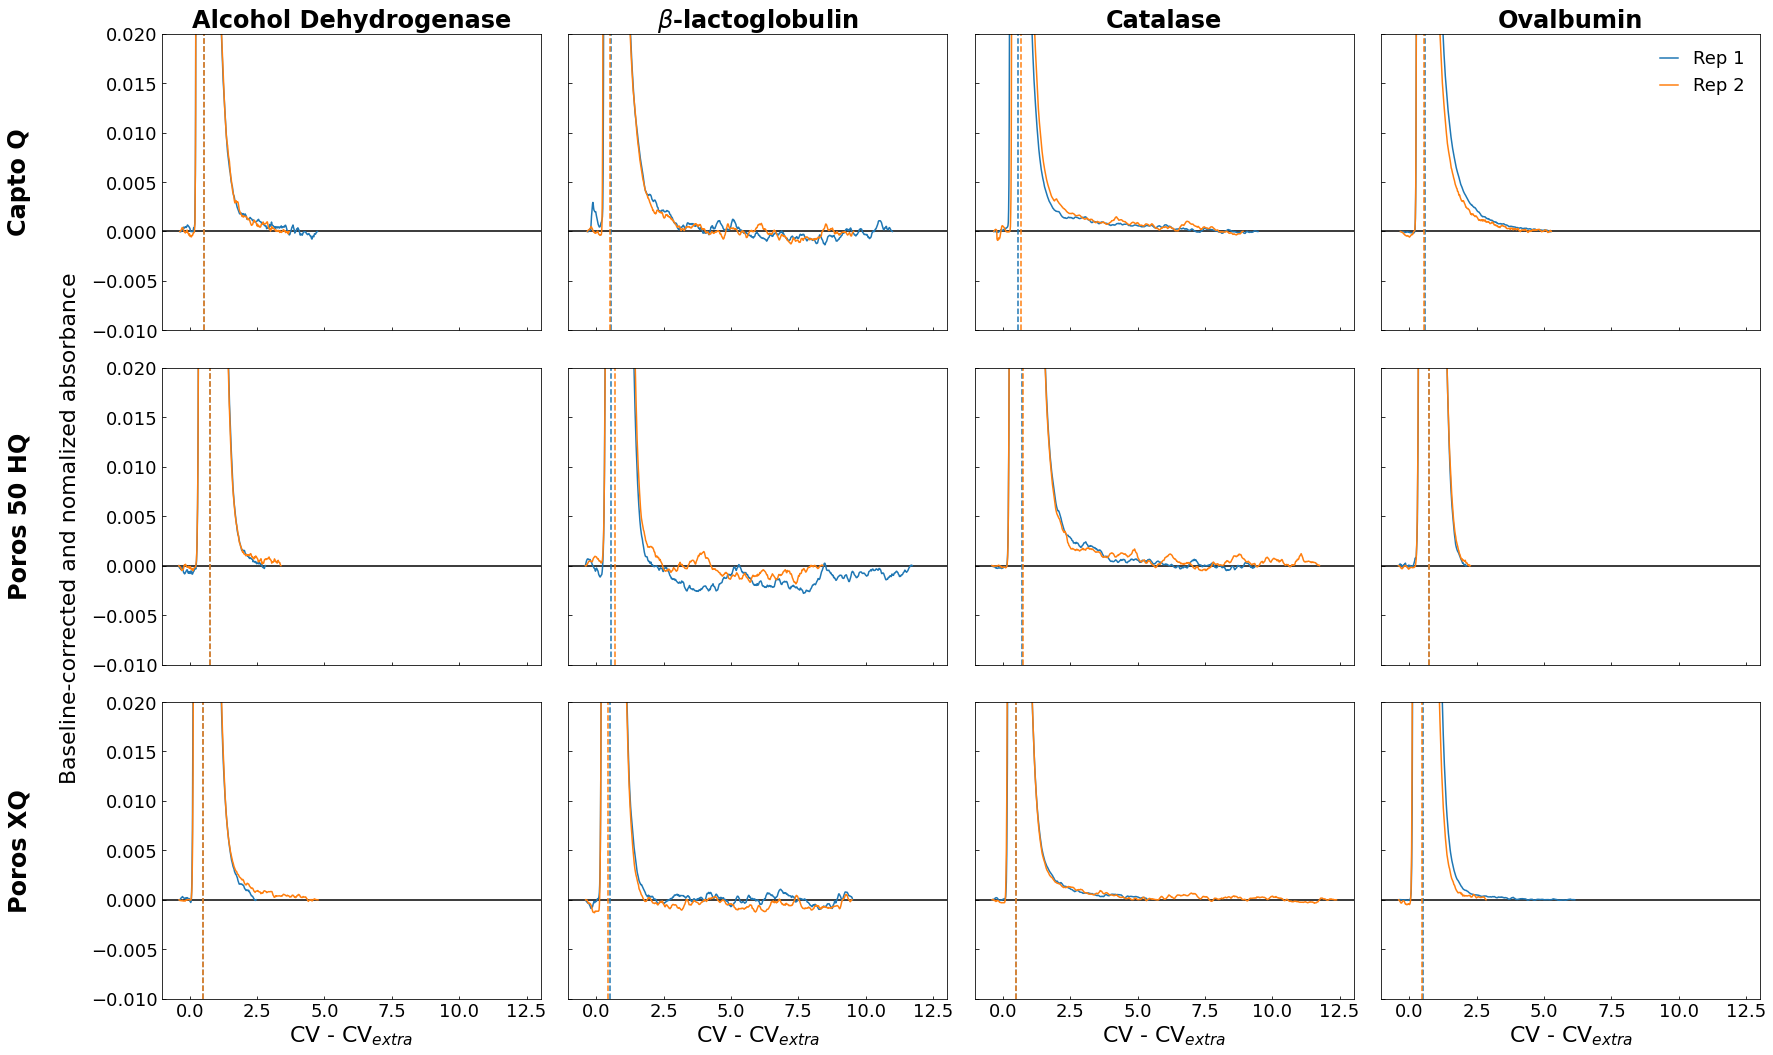

In [45]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV - CV$_{extra}$', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
        ax[n_res, n_pro].axhline(color='black')
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, 'Baseline-corrected and nomalized absorbance', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for i1, f1 in enumerate(files):
    data_1 = data_files[f1]
    
    for f2 in files[i1+1:]:
        data_2 = data_files[f2]
        
        if data_1.protein == data_2.protein and data_1.resin == data_2.resin and data_1.nacl == data_2.nacl and data_1.nacl > 900:
            n_pro = potein_number[data_1.protein]
            n_res = resin_number[data_1.resin]
            ax[n_res, n_pro].plot(data_1.df.cv - data_1.column.cv_extra, data_1.df.absorb_corrected/data_1.df.absorb_corrected.max(), label='Rep 1')
            ax[n_res, n_pro].axvline(data_1.cv_moment, linestyle='--', color=ax[n_res, n_pro].get_lines()[-1].get_color())
            ax[n_res, n_pro].plot(data_2.df.cv - data_2.column.cv_extra, data_2.df.absorb_corrected/data_2.df.absorb_corrected.max(), label='Rep 2')
            ax[n_res, n_pro].axvline(data_2.cv_moment, linestyle='--', color=ax[n_res, n_pro].get_lines()[-1].get_color())

# Set axis scales
ax[0, 0].set_ylim(-0.01, .02)
# ax[0, 0].set_xlim(0, 2)
# ax[0, 0].set_xscale('log')

ax[0, 3].legend(loc='best', handlelength=1, frameon=False)

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
# fig.savefig('./images/chromatograms_normalized_baseline_corrected_flowthrough_zoomed.png', dpi=300)

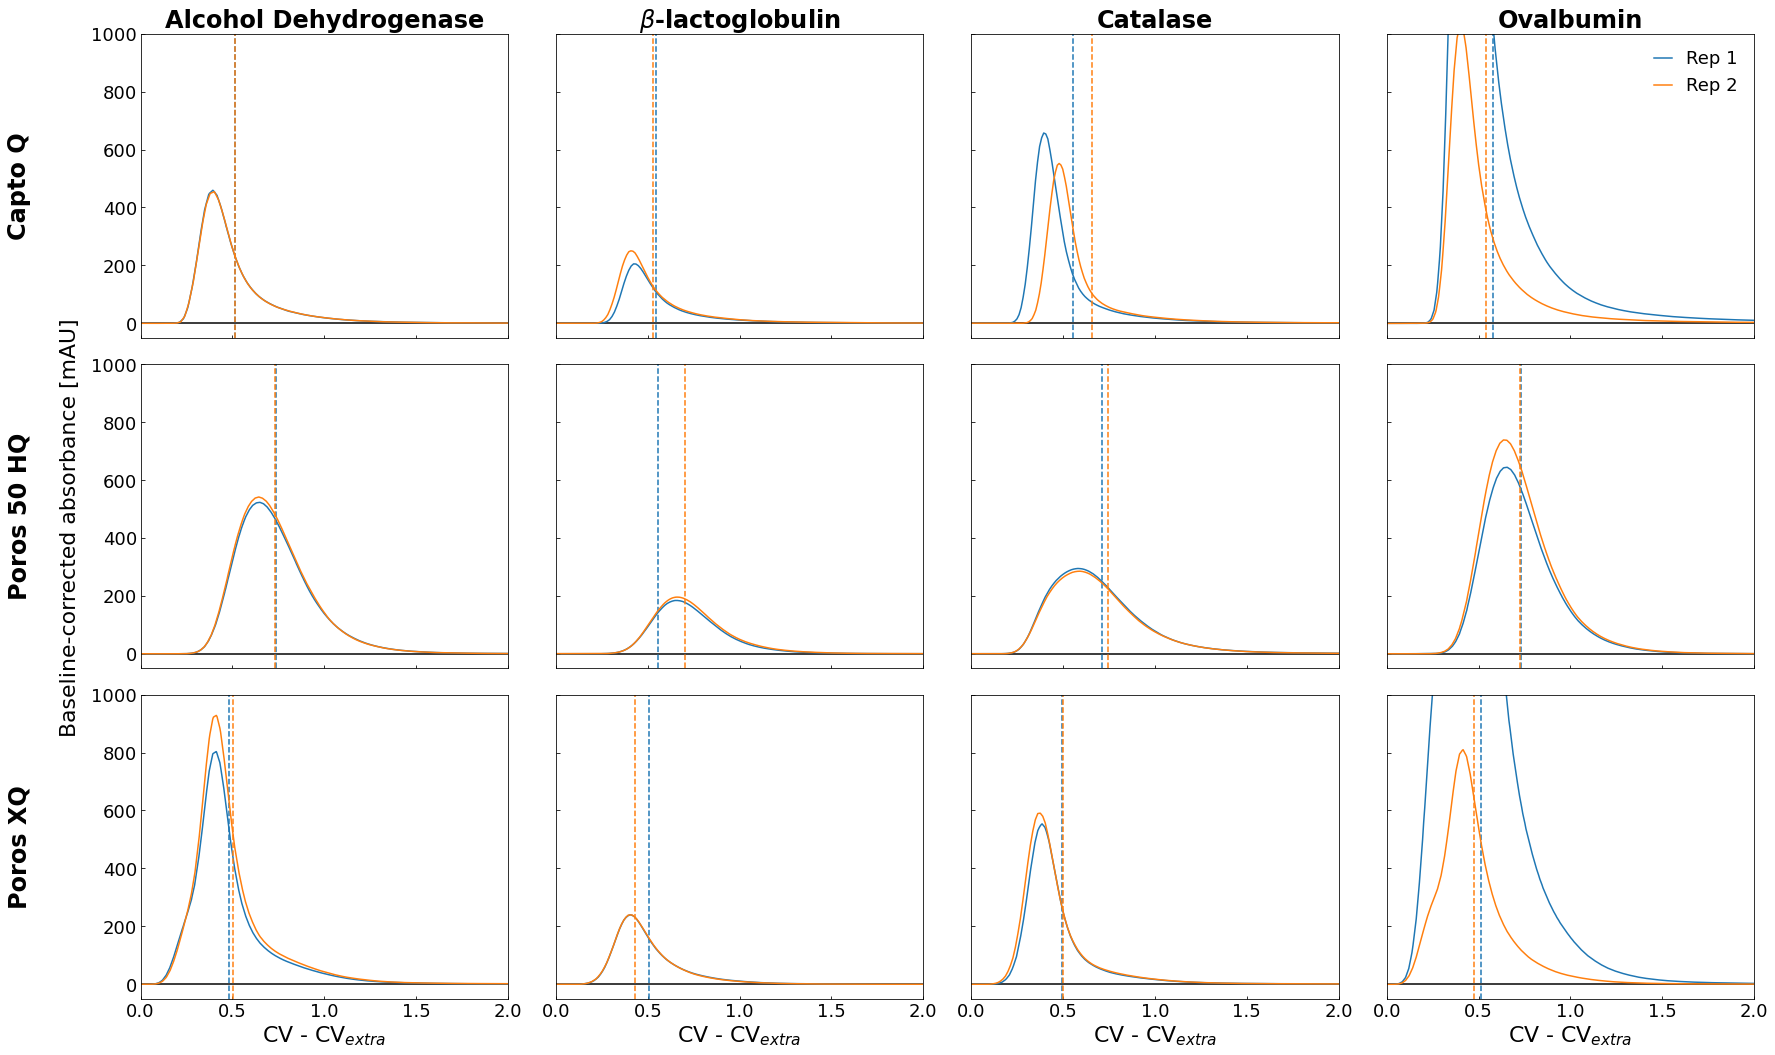

In [47]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV - CV$_{extra}$', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
        ax[n_res, n_pro].axhline(color='black')
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, 'Baseline-corrected absorbance [mAU]', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for i1, f1 in enumerate(files):
    data_1 = data_files[f1]
    
    for f2 in files[i1+1:]:
        data_2 = data_files[f2]
        
        if data_1.protein == data_2.protein and data_1.resin == data_2.resin and data_1.nacl == data_2.nacl and data_1.nacl > 900:
            n_pro = potein_number[data_1.protein]
            n_res = resin_number[data_1.resin]
            ax[n_res, n_pro].plot(data_1.df.cv - data_1.column.cv_extra, data_1.df.absorb_corrected, label='Rep 1')
            ax[n_res, n_pro].axvline(data_1.cv_moment, linestyle='--', color=ax[n_res, n_pro].get_lines()[-1].get_color())
            ax[n_res, n_pro].plot(data_2.df.cv - data_2.column.cv_extra, data_2.df.absorb_corrected, label='Rep 2')
            ax[n_res, n_pro].axvline(data_2.cv_moment, linestyle='--', color=ax[n_res, n_pro].get_lines()[-1].get_color())

# Set axis scales
ax[0, 0].set_ylim(-50, 1000)
ax[0, 0].set_xlim(0, 2)
# ax[0, 0].set_xscale('log')

ax[0, 3].legend(loc='best', handlelength=1, frameon=False)

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
# fig.savefig('./images/chromatograms_baseline_corrected_flowthrough_zoomed.png', dpi=300)

# Second cleaning

- Removal of data > 5 CV for blg on phq and pxq at 956 mM NaCl

In [198]:
files_to_cut = []
for f in files:
    data = data_files[f]
    if data.nacl > 900 and 'blg' in f:
        files_to_cut.append(f)
print(files_to_cut)

['blg_caq_956_rep_1', 'blg_caq_956_rep_2', 'blg_phq_956_rep_1', 'blg_phq_956_rep_2', 'blg_pxq_956_rep_1', 'blg_pxq_956_rep_2']


In [199]:
for f in files_to_cut:
    data = data_files[f]
    data.df.drop(index=data.df[data.df.cv - data.column.cv_extra > 4].index, inplace=True)
    data.clean_data()
    data.get_first_moment()

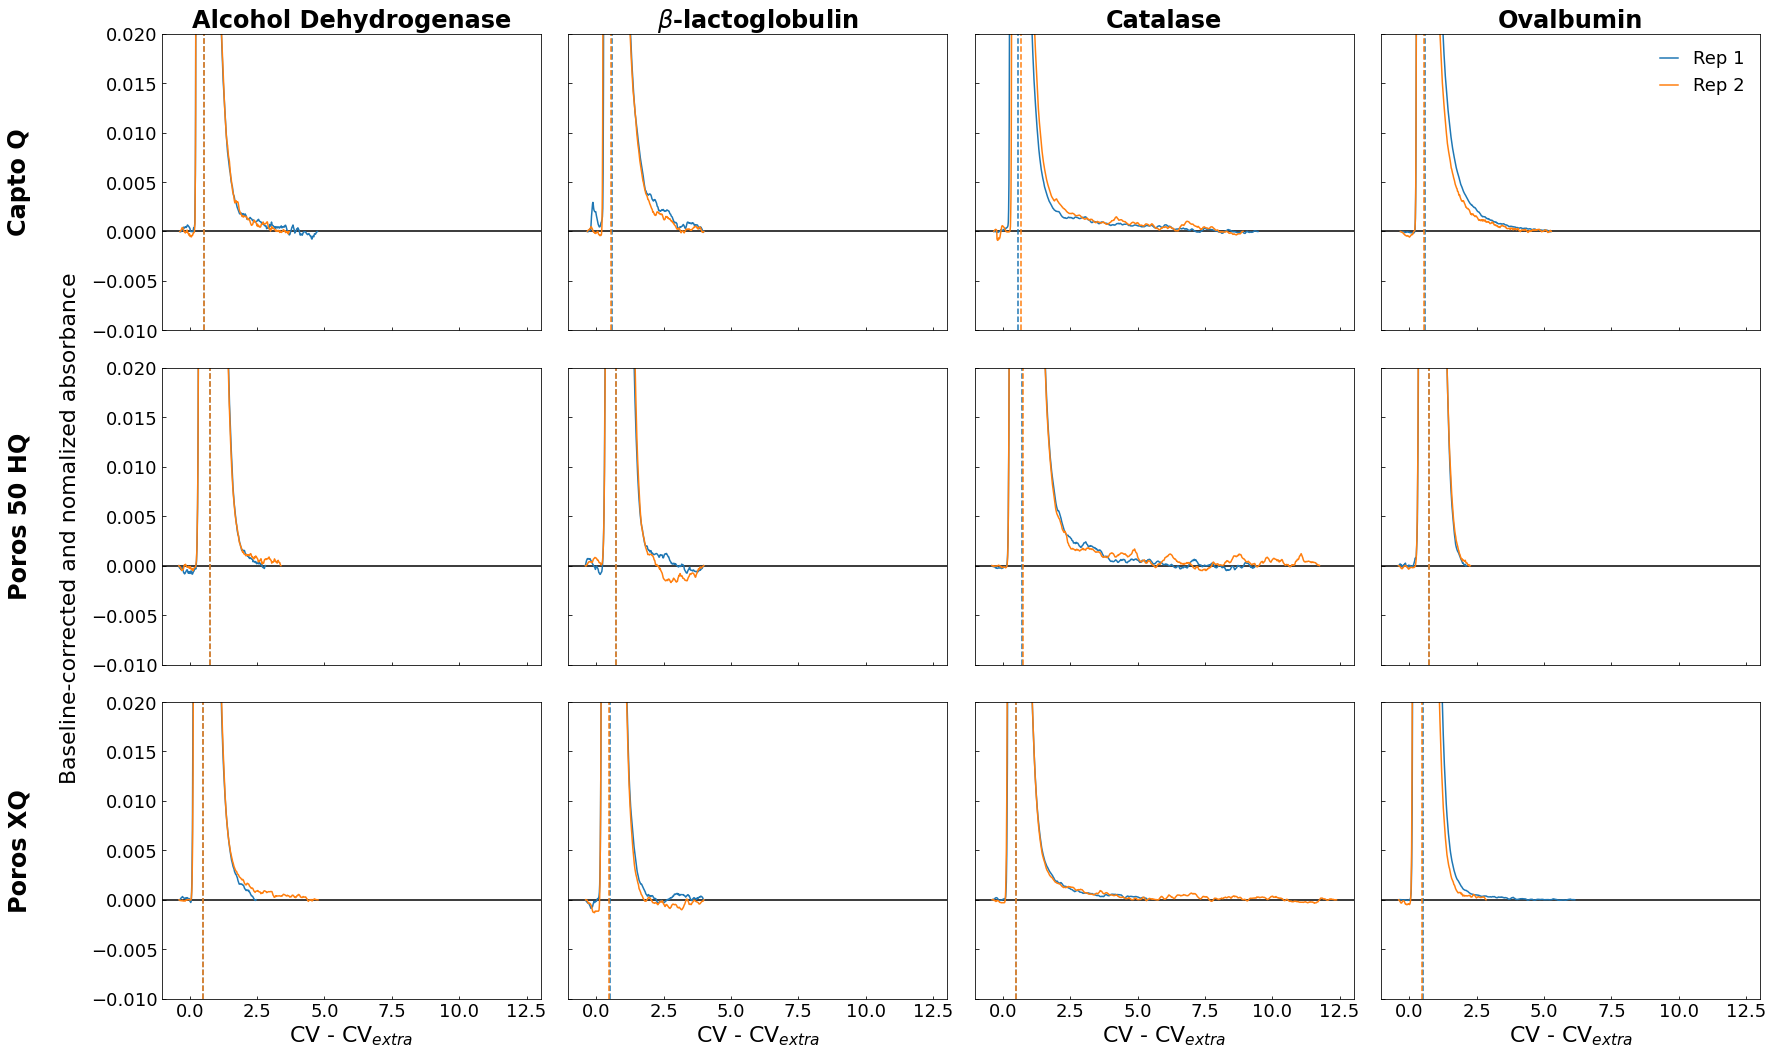

In [27]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV - CV$_{extra}$', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
        ax[n_res, n_pro].axhline(color='black')
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, 'Baseline-corrected and nomalized absorbance', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for i1, f1 in enumerate(files):
    data_1 = data_files[f1]
    
    for f2 in files[i1+1:]:
        data_2 = data_files[f2]
        
        if data_1.protein == data_2.protein and data_1.resin == data_2.resin and data_1.nacl == data_2.nacl and data_1.nacl > 900:
            n_pro = potein_number[data_1.protein]
            n_res = resin_number[data_1.resin]
            ax[n_res, n_pro].plot(data_1.df.cv - data_1.column.cv_extra, data_1.df.absorb_corrected/data_1.df.absorb_corrected.max(), label='Rep 1')
            ax[n_res, n_pro].axvline(data_1.cv_moment, linestyle='--', color=ax[n_res, n_pro].get_lines()[-1].get_color())
            ax[n_res, n_pro].plot(data_2.df.cv - data_2.column.cv_extra, data_2.df.absorb_corrected/data_2.df.absorb_corrected.max(), label='Rep 2')
            ax[n_res, n_pro].axvline(data_2.cv_moment, linestyle='--', color=ax[n_res, n_pro].get_lines()[-1].get_color())

# Set axis scales
ax[0, 0].set_ylim(-0.01, .02)
# ax[0, 0].set_xlim(0, 2)
# ax[0, 0].set_xscale('log')

ax[0, 3].legend(loc='best', handlelength=1, frameon=False)

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
# fig.savefig('./images/chromatograms_normalized_baseline_corrected_flowthrough_zoomed_cut.png', dpi=300)

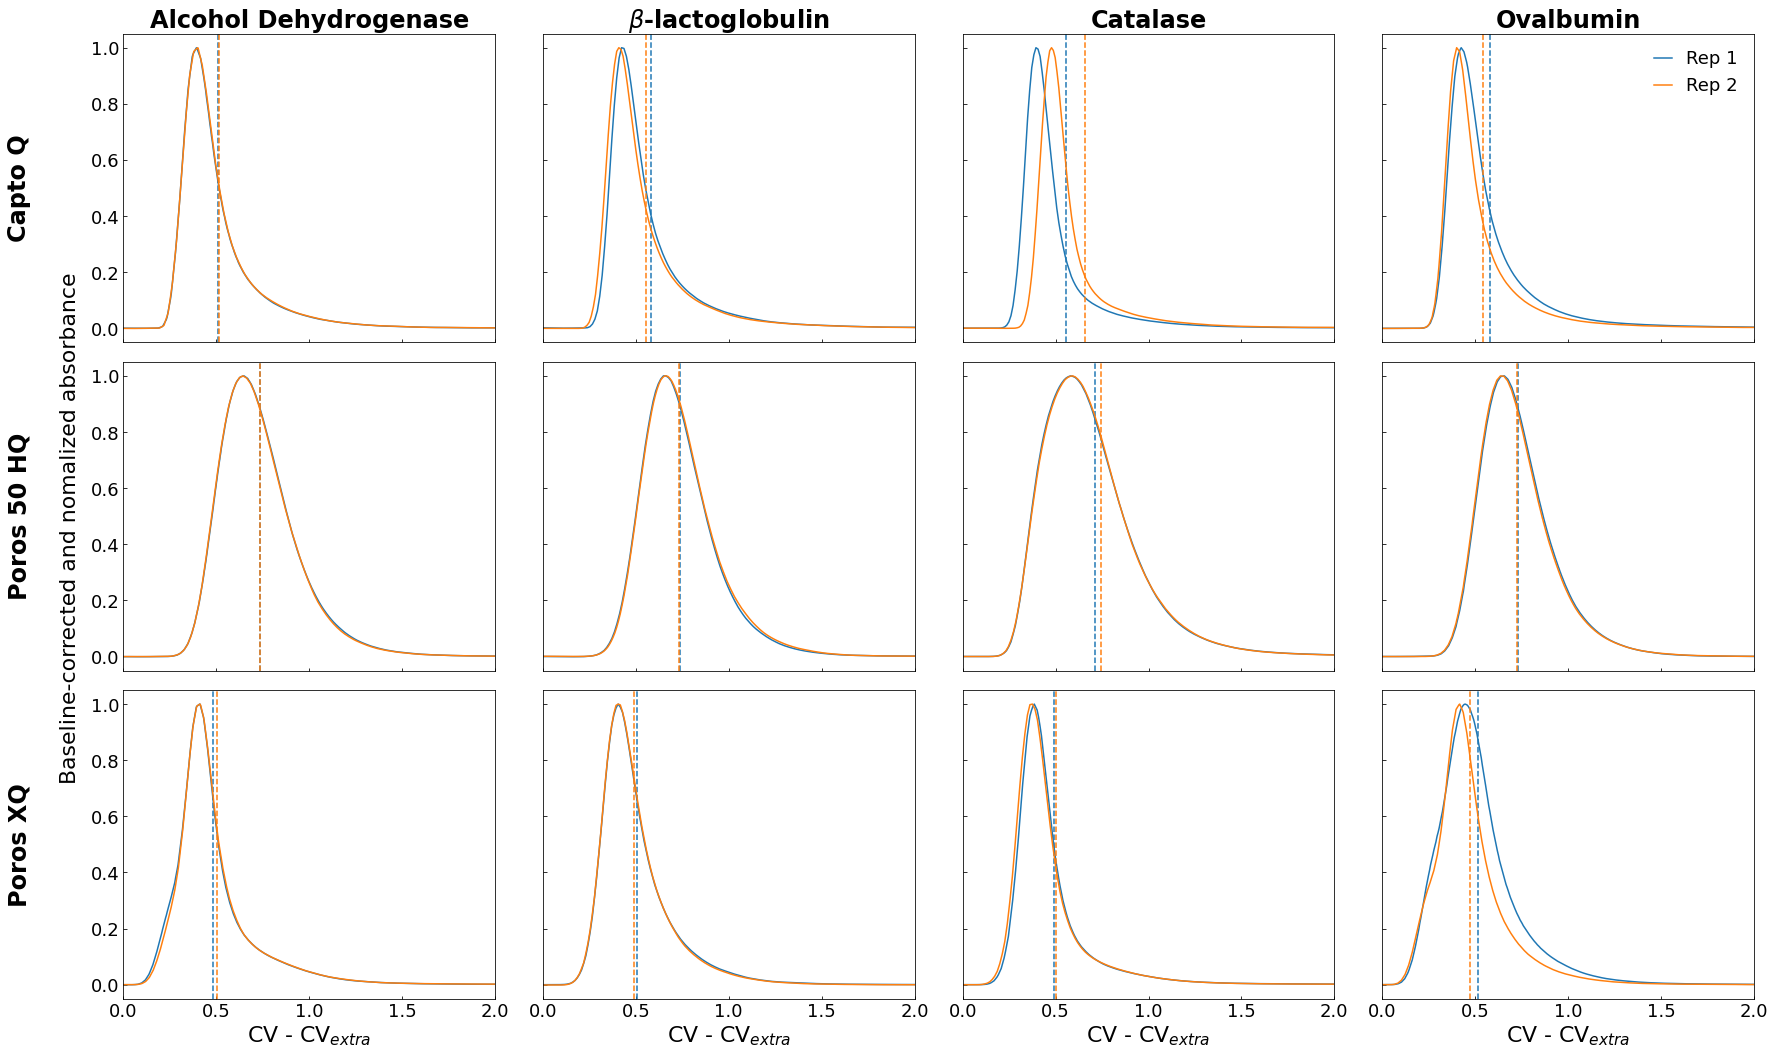

In [29]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV - CV$_{extra}$', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, 'Baseline-corrected and nomalized absorbance', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for i1, f1 in enumerate(files):
    data_1 = data_files[f1]
    
    for f2 in files[i1+1:]:
        data_2 = data_files[f2]
        
        if data_1.protein == data_2.protein and data_1.resin == data_2.resin and data_1.nacl == data_2.nacl and data_1.nacl > 900:
            n_pro = potein_number[data_1.protein]
            n_res = resin_number[data_1.resin]
            ax[n_res, n_pro].plot(data_1.df.cv - data_1.column.cv_extra, data_1.df.absorb_corrected/data_1.df.absorb_corrected.max(), label='Rep 1')
            ax[n_res, n_pro].axvline(data_1.cv_moment, linestyle='--', color=ax[n_res, n_pro].get_lines()[-1].get_color())
            ax[n_res, n_pro].plot(data_2.df.cv - data_2.column.cv_extra, data_2.df.absorb_corrected/data_2.df.absorb_corrected.max(), label='Rep 2')
            ax[n_res, n_pro].axvline(data_2.cv_moment, linestyle='--', color=ax[n_res, n_pro].get_lines()[-1].get_color())

# Set axis scales
ax[0, 0].set_ylim(-0.05, 1.05)
ax[0, 0].set_xlim(0, 2)
# ax[0, 0].set_xscale('log')

ax[0, 3].legend(loc='best', handlelength=1, frameon=False)

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
# fig.savefig('./images/chromatograms_normalized_baseline_corrected_flowthrough_cut.png', dpi=300)

## Get $\varepsilon_t$

In [200]:
results = []

for i1, f1 in enumerate(files):
    data_1 = data_files[f1]

    for f2 in files[i1+1:]:
        data_2 = data_files[f2]
        
        if data_1.protein == data_2.protein and data_1.resin == data_2.resin and data_1.nacl == data_2.nacl and data_1.nacl > 900:
            results.append([data_1.protein, data_1.resin, data_1.cv_moment, data_2.cv_moment])
            
porosities = pd.DataFrame(results, columns=['protein', 'resin', 'eps_t_1', 'eps_t_2'])
porosities['eps_t'] = (porosities.eps_t_1 + porosities.eps_t_2)/2.0
for i, cont in porosities.iterrows():
    porosities.at[i, 'std_dev'] = np.std(np.array([cont.eps_t_1, cont.eps_t_2]), ddof=1)
porosities['rsd'] = porosities['std_dev']/porosities['eps_t'] * 100.0
porosities['var'] = porosities['std_dev']**2
porosities['phi'] = (1.0 - porosities.eps_t)/porosities.eps_t

pooled_var = porosities['var'].sum()/len(porosities)
pooled_std = np.sqrt(pooled_var)
pooled_std

0.026469176586767517

In [127]:
# porosities.to_csv('./data/porosities.csv', index=False)
# porosities.sort_values(by='resin')

## Plot porosity data

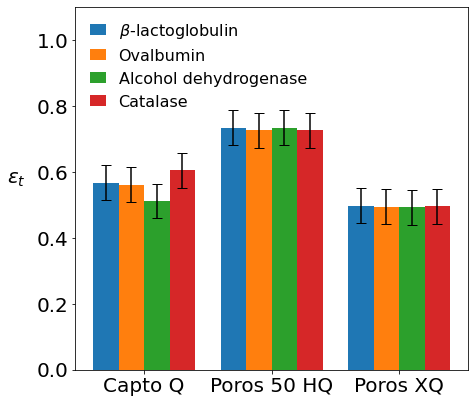

In [202]:
eps_t_map = {}
for pro in proteins:
    df = porosities[porosities.protein == pro]
    eps_t_map[pro] = df.eps_t.values


fig, ax = my_plot.instantiate_fig()
x = np.arange(len(resins))  
ax.set_xticks(x)
ax.set_xticklabels(resin_name.values())
ax.set_ylabel(r'$\varepsilon_t$', rotation=0, labelpad=20)
width = 0.2

for i, pro in enumerate(['blg', 'ova', 'adh', 'cat']):
    plt.bar(x + width*(i-1.5), eps_t_map[pro], width, label=protein_name[pro])
    plt.errorbar(x + width*(i-1.5), eps_t_map[pro], yerr=2*pooled_std, fmt=' ', color='black', capsize=5)

ax.set_ylim(0, 1.1)
my_plot.set_layout(fig, ax, legend=True, loc='upper left', fontsize=16)
# fig.savefig('./images/total_porosities.png', dpi=300)

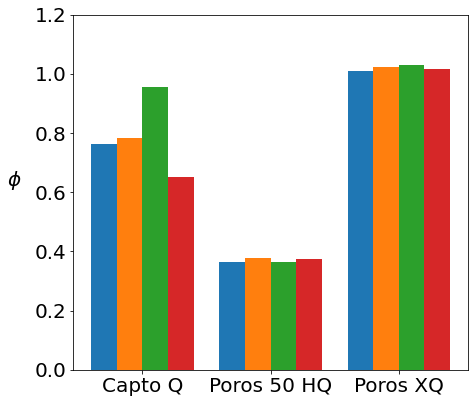

In [203]:
phi_map = {}
for pro in proteins:
    df = porosities[porosities.protein == pro]
    phi_map[pro] = df.phi.values


fig, ax = my_plot.instantiate_fig()
x = np.arange(len(resins))  
ax.set_xticks(x)
ax.set_xticklabels(resin_name.values())
ax.set_ylabel(r'$\phi$', rotation=0, labelpad=20)
width = 0.2

for i, pro in enumerate(['blg', 'ova', 'adh', 'cat']):
    plt.bar(x + width*(i-1.5), phi_map[pro], width, label=protein_name[pro])

ax.set_ylim(0, 1.2)
my_plot.set_layout(fig)
# fig.savefig('./images/phase_ratios.png', dpi=300)

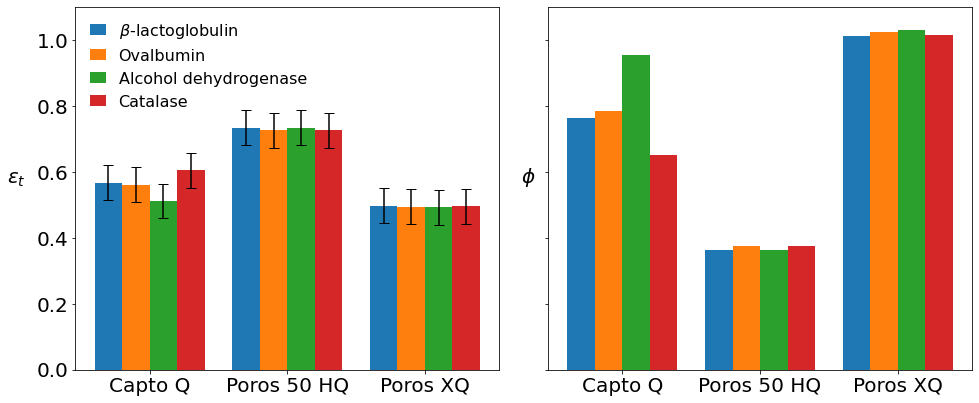

In [206]:
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(14, 6, forward=True)
font = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)

ax[0].set_ylabel(r'$\varepsilon_t$', rotation=0, labelpad=20)
ax[1].set_ylabel(r'$\phi$', rotation=0, labelpad=20)

x = np.arange(len(resins))
width = 0.2

for i in range(2):
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(resin_name.values())

for i, pro in enumerate(['blg', 'ova', 'adh', 'cat']):
    ax[0].bar(x + width*(i-1.5), eps_t_map[pro], width, label=protein_name[pro])
    ax[0].errorbar(x + width*(i-1.5), eps_t_map[pro], yerr=2*pooled_std, fmt=' ', color='black', capsize=5)
    ax[1].bar(x + width*(i-1.5), phi_map[pro], width, label=protein_name[pro])

ax[0].set_ylim(0, 1.1)
my_plot.set_layout(fig, ax[0], legend=True, loc='upper left', fontsize=16)
fig.savefig('./images/total_porosities_and_phase_ratios.png', dpi=300)

# Estimate $k'$ and $K_{eq}$

(Restart point)

In [209]:
folder = './data/split_files/'
files  = os.listdir(folder)
files.sort()

data_files = {}
for f in files:
    data_files[f] = my_fun.run_data(folder, f, buffer_ion_str=41)
    
# Optional, since I'm loading eps_t/phi and not using these data below
for f in ['blg_caq_956_rep_1', 'blg_caq_956_rep_2', 'blg_phq_956_rep_1', 'blg_phq_956_rep_2', 'blg_pxq_956_rep_1', 'blg_pxq_956_rep_2']:
    data = data_files[f]
    data.df.drop(index=data.df[data.df.cv - data.column.cv_extra > 4].index, inplace=True)
    data.clean_data()
    data.get_first_moment()

# Not optional
for f in files:
    data = data_files[f]
    data.get_eps_t()
    data.get_phi()     # optional
    data.get_kprime()
    data.get_keq()

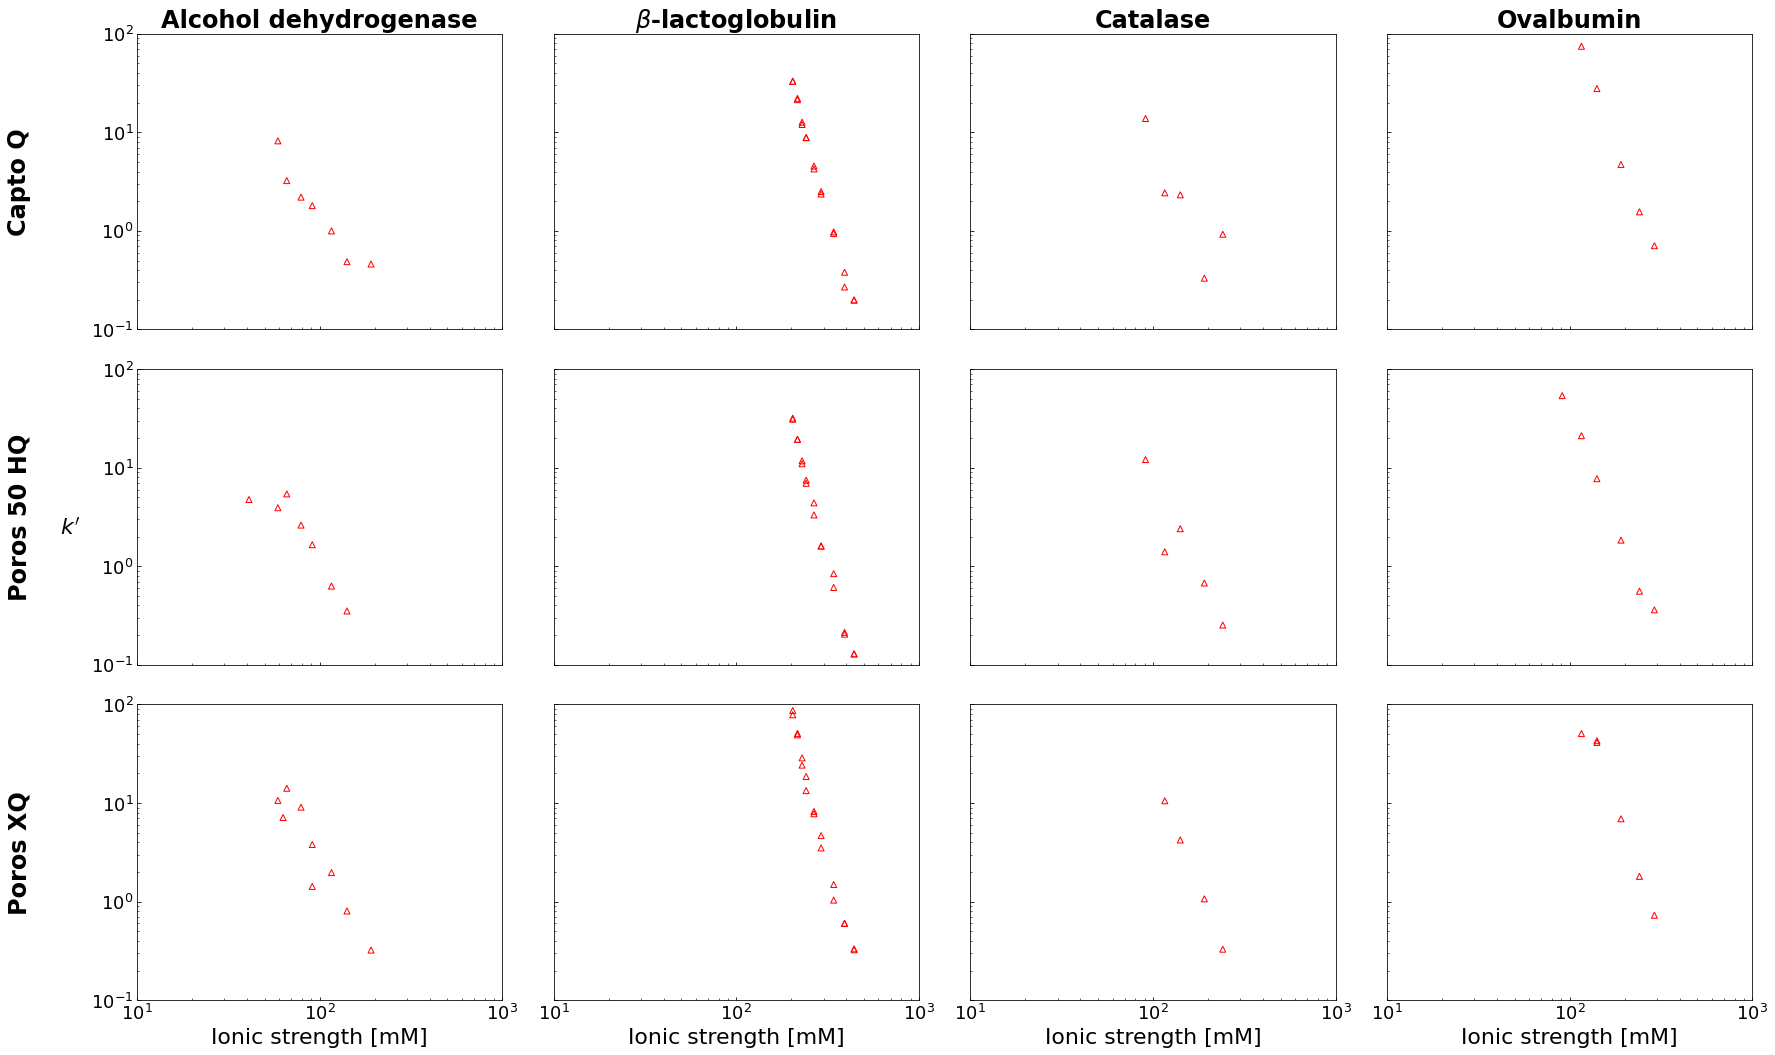

In [210]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('Ionic strength [mM]', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, '$k\'$', va='center', rotation=0, fontsize=label_size)

# Add the data
for f in files:
    data = data_files[f]
    if data.nacl < 900:
        n_pro = potein_number[data.protein]
        n_res = resin_number[data.resin]
        ax[n_res, n_pro].scatter(data.ion_str, data.kprime, marker='^', facecolors='none', edgecolors='red')

# Set axis scales
ax[0, 0].set_ylim(0.1, 100)
ax[0, 0].set_xlim(10, 1000)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
fig.savefig('./images/kprime_raw.png', dpi=300)

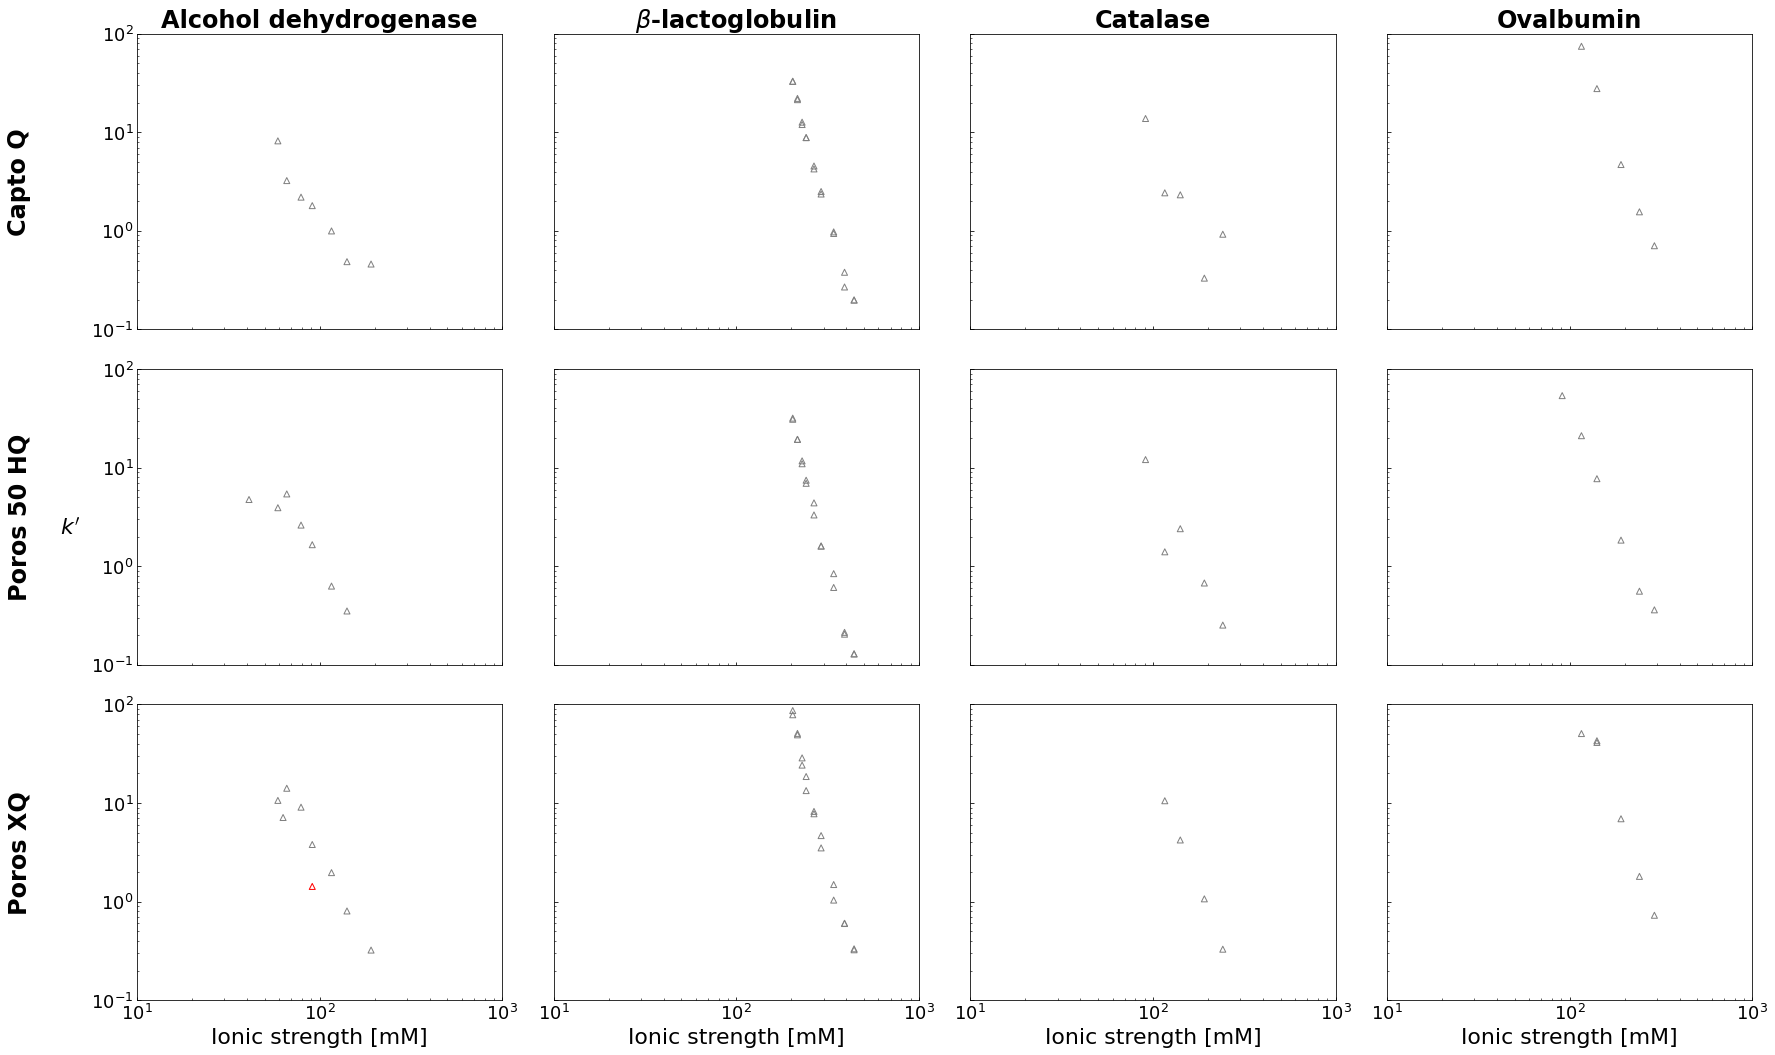

In [211]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('Ionic strength [mM]', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, '$k\'$', va='center', rotation=0, fontsize=label_size)

# Add the data
for f in files:
    data = data_files[f]
    if data.nacl < 900:
        n_pro = potein_number[data.protein]
        n_res = resin_number[data.resin]
        
        if f in ['adh_pxq_50_rep_2']:
            color='red'
        else:
            color='grey'
        ax[n_res, n_pro].scatter(data.ion_str, data.kprime, marker='^', facecolors='none', edgecolors=color)

# Set axis scales
ax[0, 0].set_ylim(0.1, 100)
ax[0, 0].set_xlim(10, 1000)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
fig.savefig('./images/kprime_highlight_flowrate.png', dpi=300)

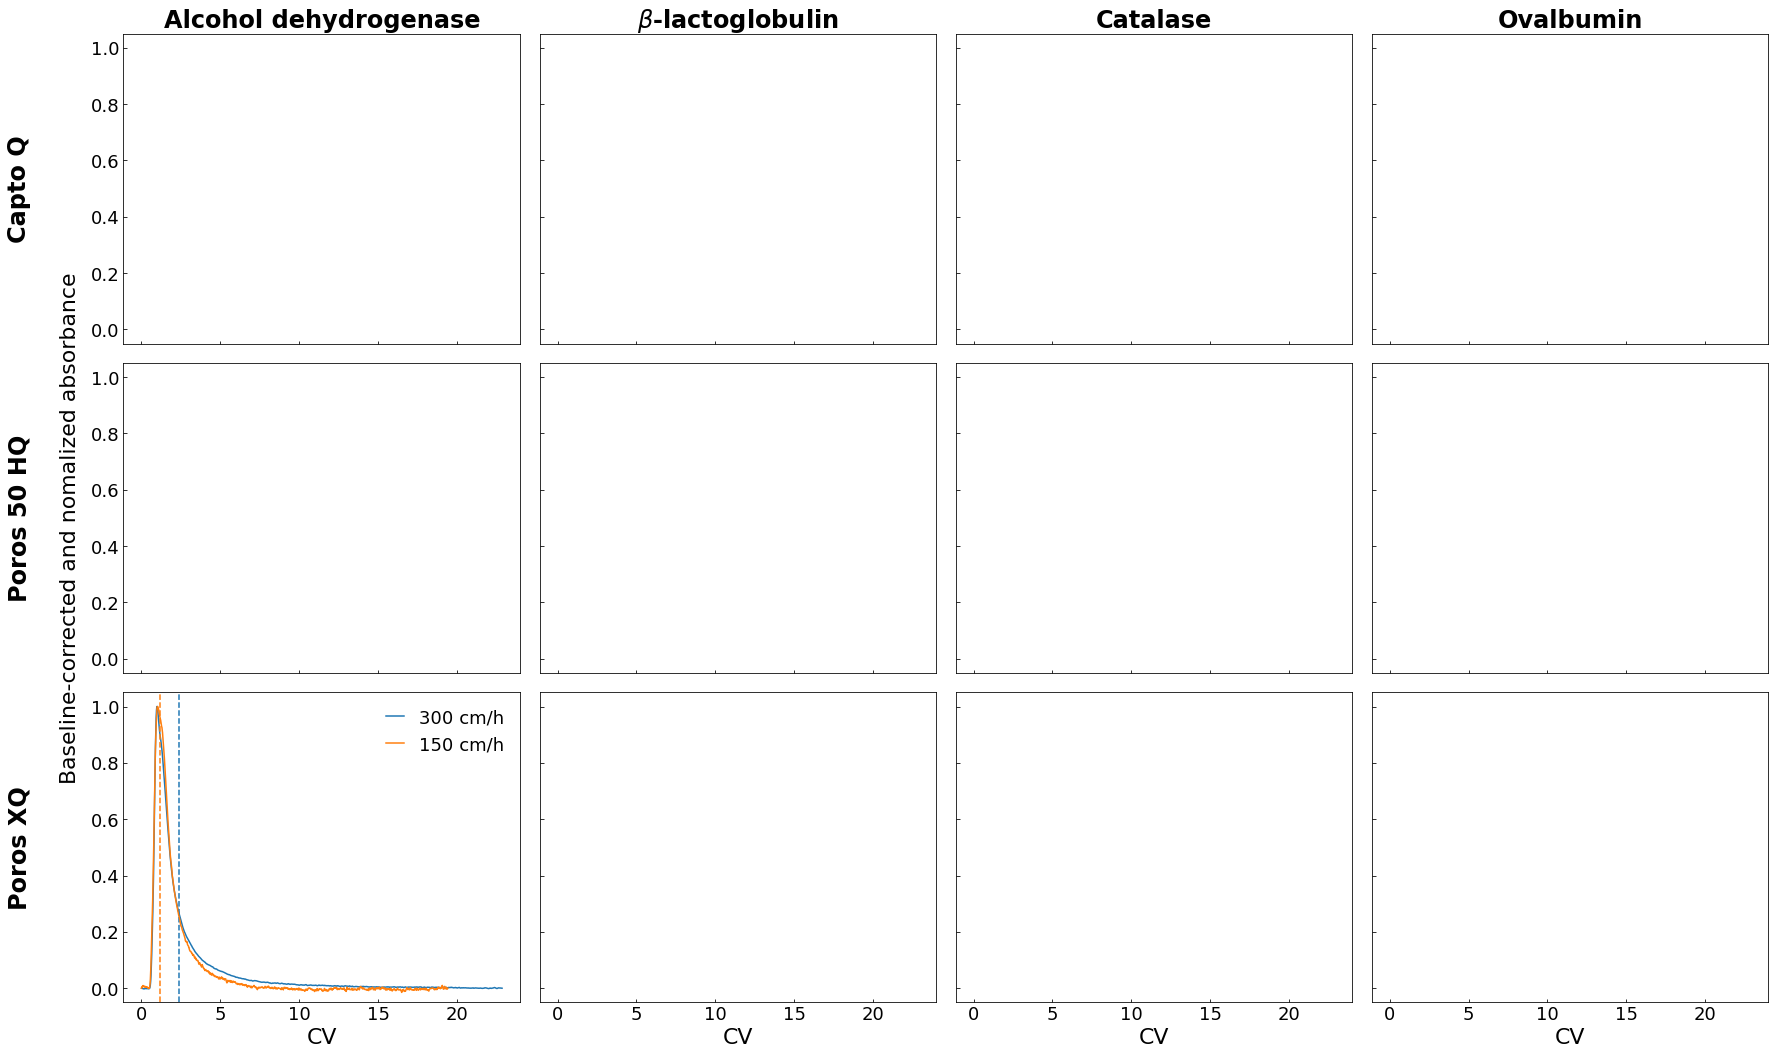

In [212]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, 'Baseline-corrected and nomalized absorbance', va='center', rotation='vertical', fontsize=label_size)

# Add the data

data_1 = data_files['adh_pxq_50_rep_1']
data_2 = data_files['adh_pxq_50_rep_2']
n_pro = potein_number[data_1.protein]
n_res = resin_number[data_1.resin]

ax[n_res, n_pro].plot(data_1.df.cv, data_1.df.absorb_corrected/data_1.df.absorb_corrected.max(), label='300 cm/h')
ax[n_res, n_pro].axvline(x=data1.cv_moment, color=ax[n_res, n_pro].get_lines()[-1].get_color(), linestyle='--')

ax[n_res, n_pro].plot(data_2.df.cv, data_2.df.absorb_corrected/data_2.df.absorb_corrected.max(), label='150 cm/h')
ax[n_res, n_pro].axvline(x=data2.cv_moment, color=ax[n_res, n_pro].get_lines()[-1].get_color(), linestyle='--')


# Set axis scales
ax[0, 0].set_ylim(-0.05, 1.05)
# ax[0, 0].set_xlim(0, 20)
# ax[0, 0].set_xscale('log')

ax[2, 0].legend(loc='best', handlelength=1, frameon=False)

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
fig.savefig('./images/kprime_highlight_flowrate_companion.png', dpi=300)

In [213]:
exclude_files = ['adh_caq_150_rep_1', 'adh_phq_0_rep_1', 'adh_phq_18_rep_1', 'adh_pxq_18_rep_1', 'adh_pxq_22_rep_1', 
                 'adh_pxq_50_rep_2', 'cat_caq_200_rep_1', 'cat_phq_75_rep_1', 'ova_pxq_75_rep_1']

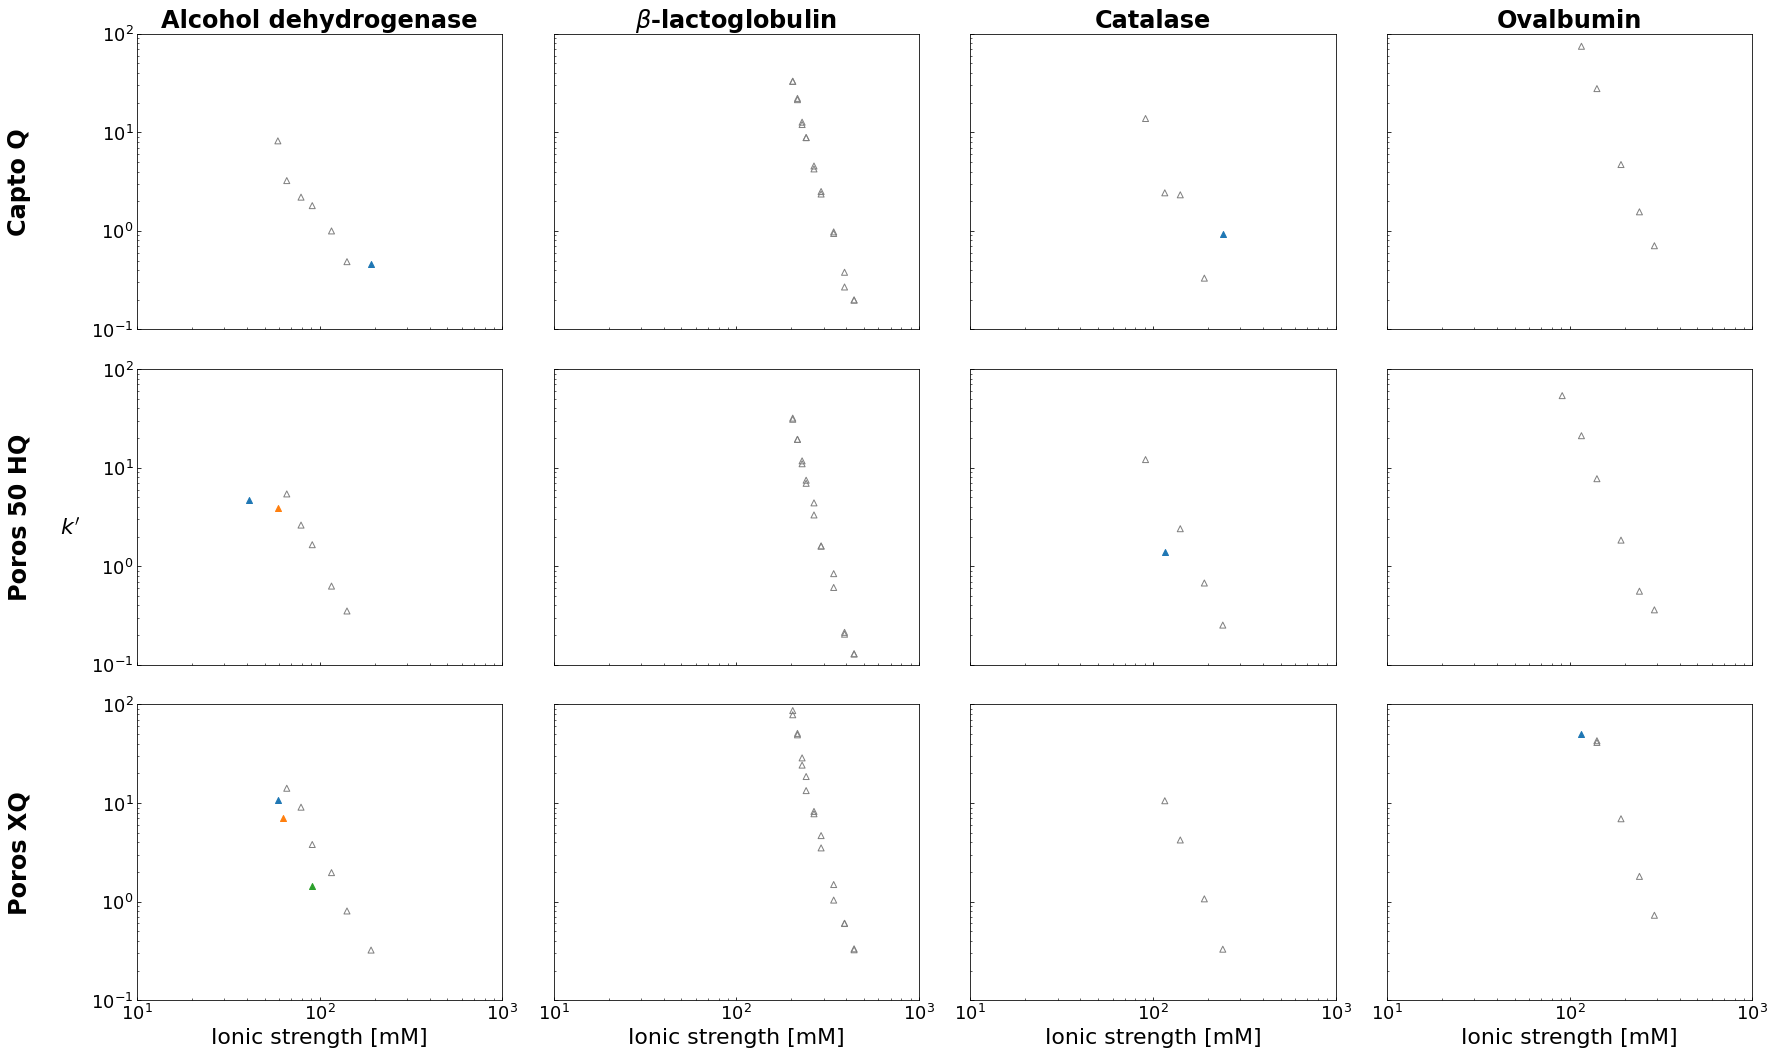

In [214]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('Ionic strength [mM]', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, '$k\'$', va='center', rotation=0, fontsize=label_size)

# Add the data
for f in files:
    data = data_files[f]
    if data.nacl < 900:
        n_pro = potein_number[data.protein]
        n_res = resin_number[data.resin]
        if f in exclude_files:
            ax[n_res, n_pro].scatter(data.ion_str, data.kprime, marker='^')
        else:
            ax[n_res, n_pro].scatter(data.ion_str, data.kprime, marker='^', facecolors='none', edgecolors='grey')
        
# Set axis scales
ax[0, 0].set_ylim(0.1, 100)
ax[0, 0].set_xlim(10, 1000)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
fig.savefig('./images/kprime_highlight_problems.png', dpi=300)

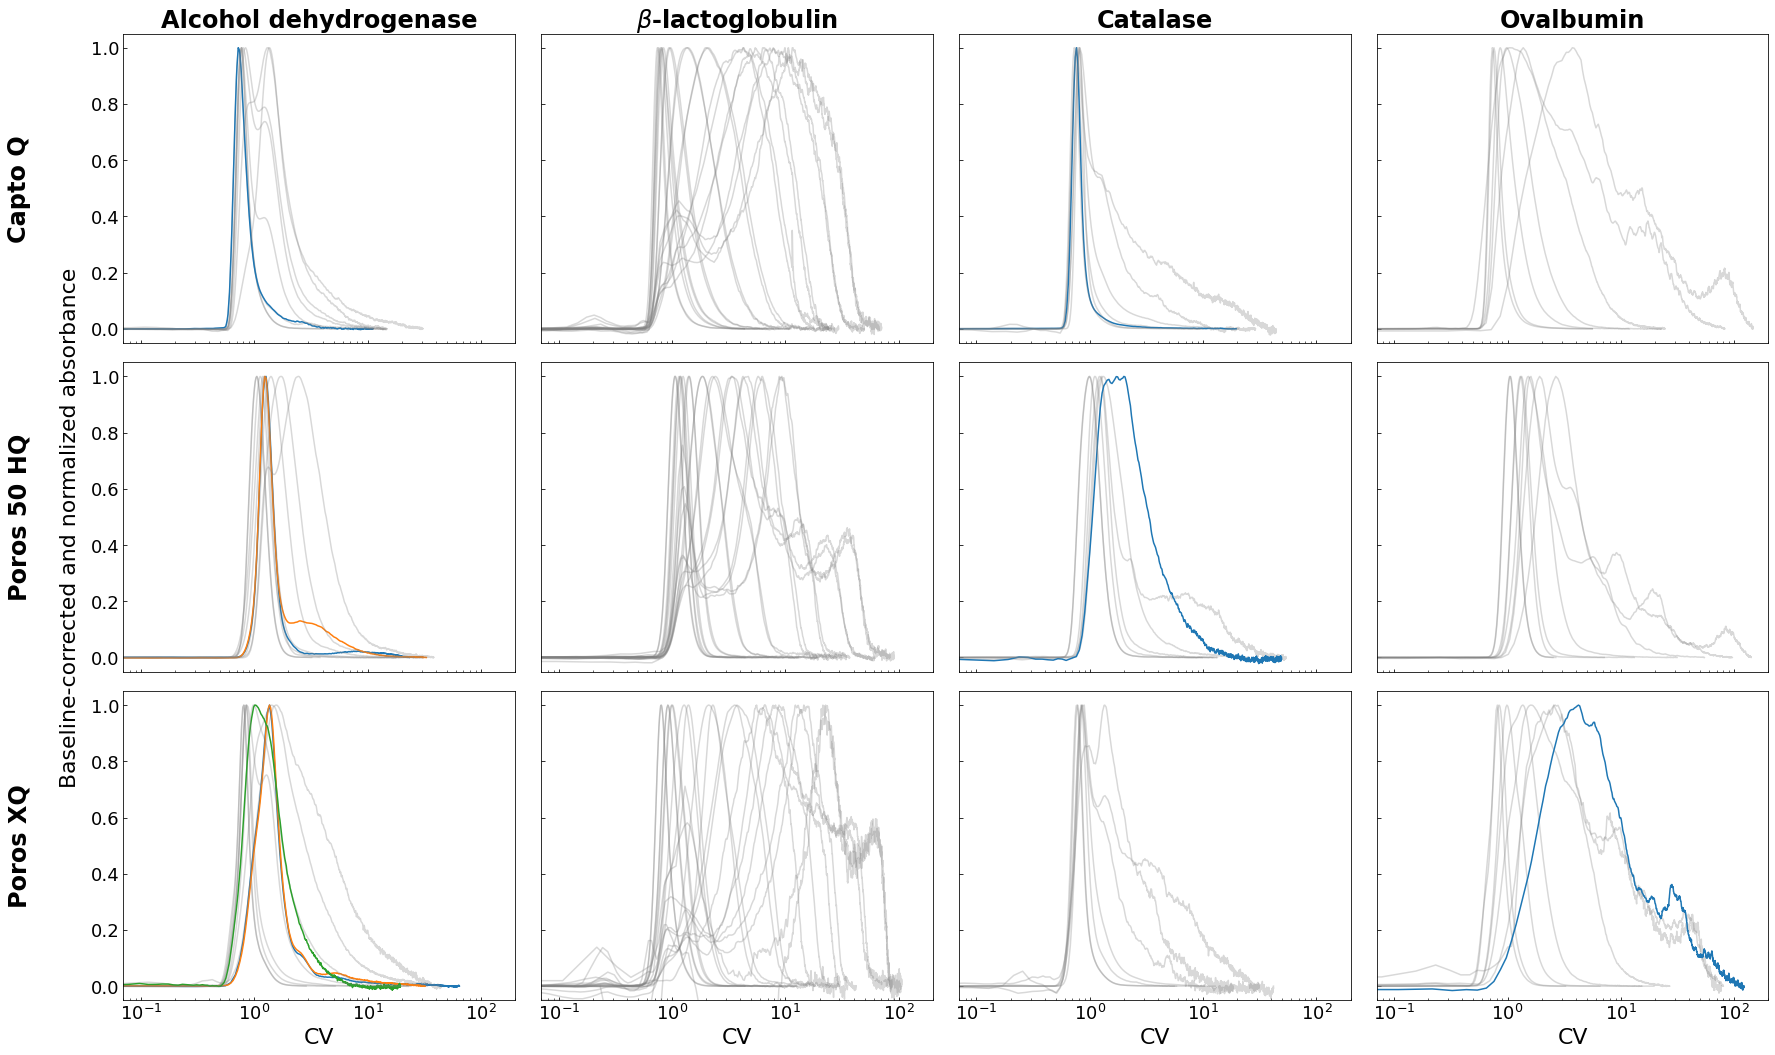

In [215]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('CV', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, 'Baseline-corrected and normalized absorbance', va='center', rotation='vertical', fontsize=label_size)

# Add the data
for i, f in enumerate(files):
    data = data_files[f]
    n_pro = potein_number[data.protein]
    n_res = resin_number[data.resin]
    if f in exclude_files:
        ax[n_res, n_pro].plot(data.df.cv, data.df.absorb_corrected/data.df.absorb_corrected.max())
    else:
        ax[n_res, n_pro].plot(data.df.cv, data.df.absorb_corrected/data.df.absorb_corrected.max(), color='grey', alpha=0.3)

# Set axis scales
ax[0, 0].set_ylim(-0.05, 1.05)
ax[0, 0].set_xlim(0.07, 200)
ax[0, 0].set_xscale('log')

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
fig.savefig('./images/kprime_highlight_problems_companion.png', dpi=300)

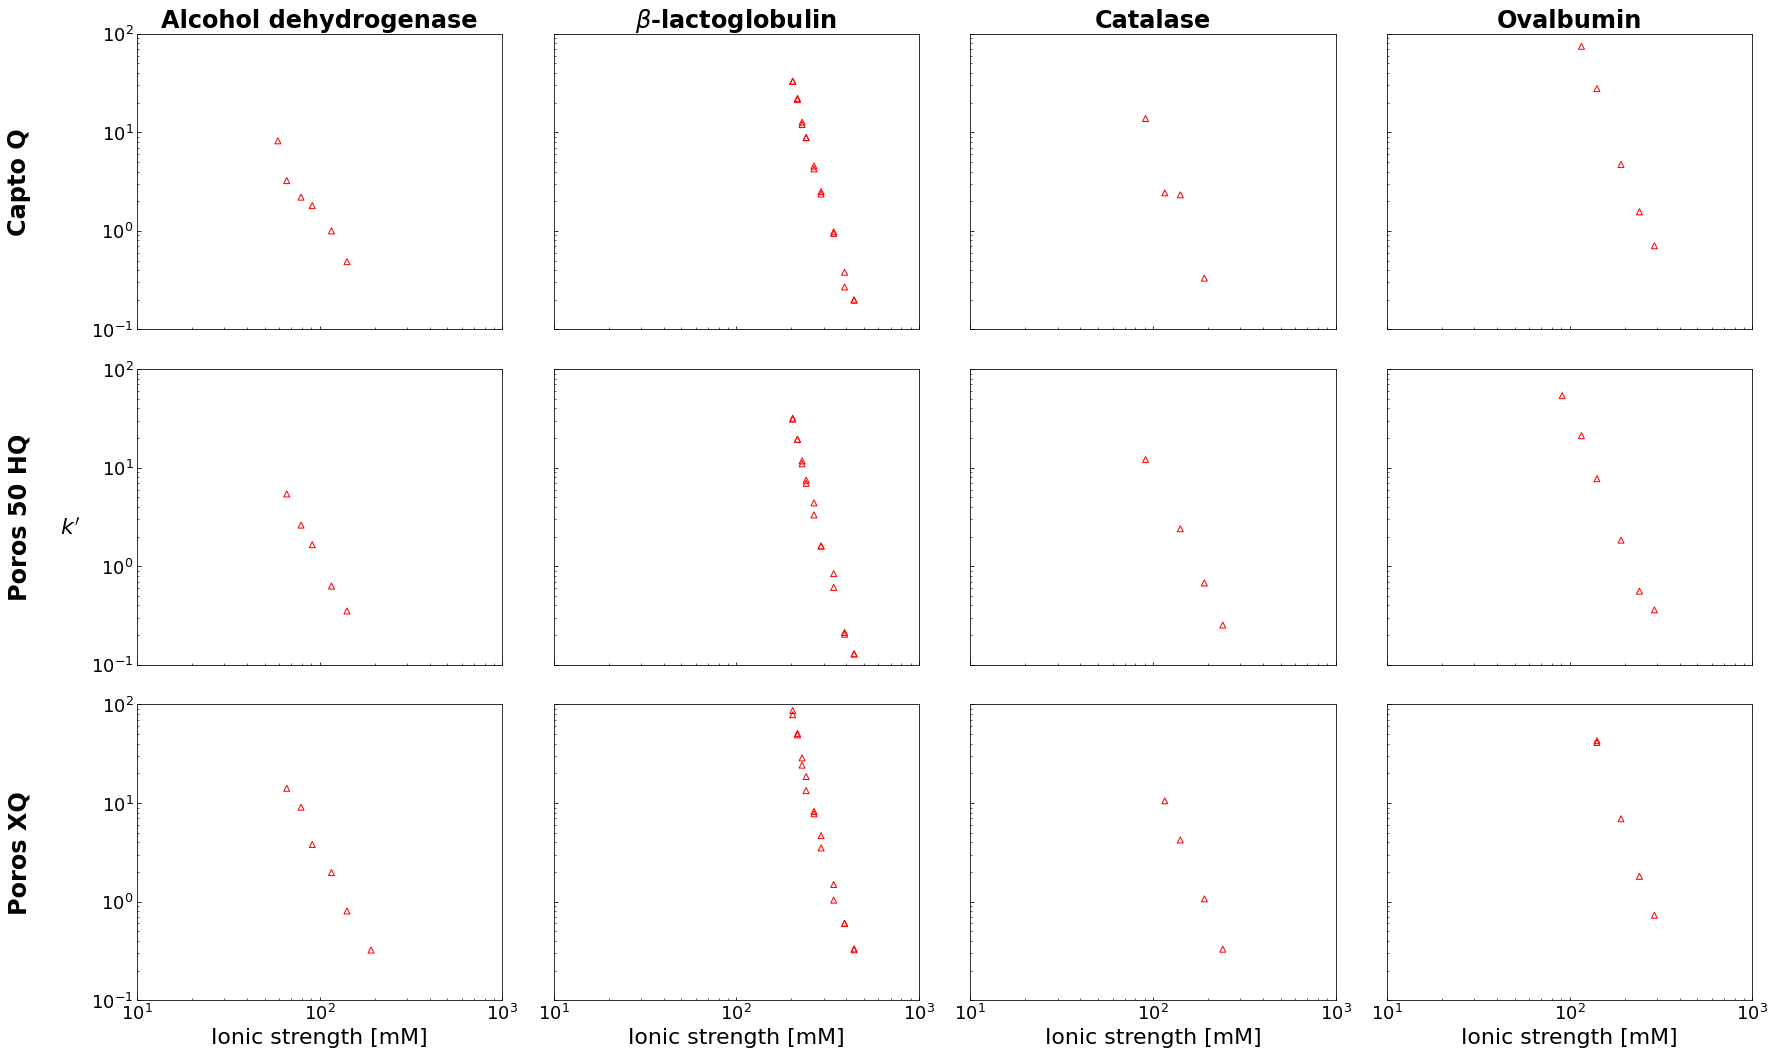

In [216]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('Ionic strength [mM]', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, '$k\'$', va='center', rotation=0, fontsize=label_size)

# Add the data
for f in files:
    data = data_files[f]
    if data.nacl < 900 and f not in exclude_files:
        n_pro = potein_number[data.protein]
        n_res = resin_number[data.resin]
        ax[n_res, n_pro].scatter(data.ion_str, data.kprime, marker='^', facecolors='none', edgecolors='red')
        
# Set axis scales
ax[0, 0].set_ylim(0.1, 100)
ax[0, 0].set_xlim(10, 1000)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
fig.savefig('./images/kprime_cherry_picked.png', dpi=300)

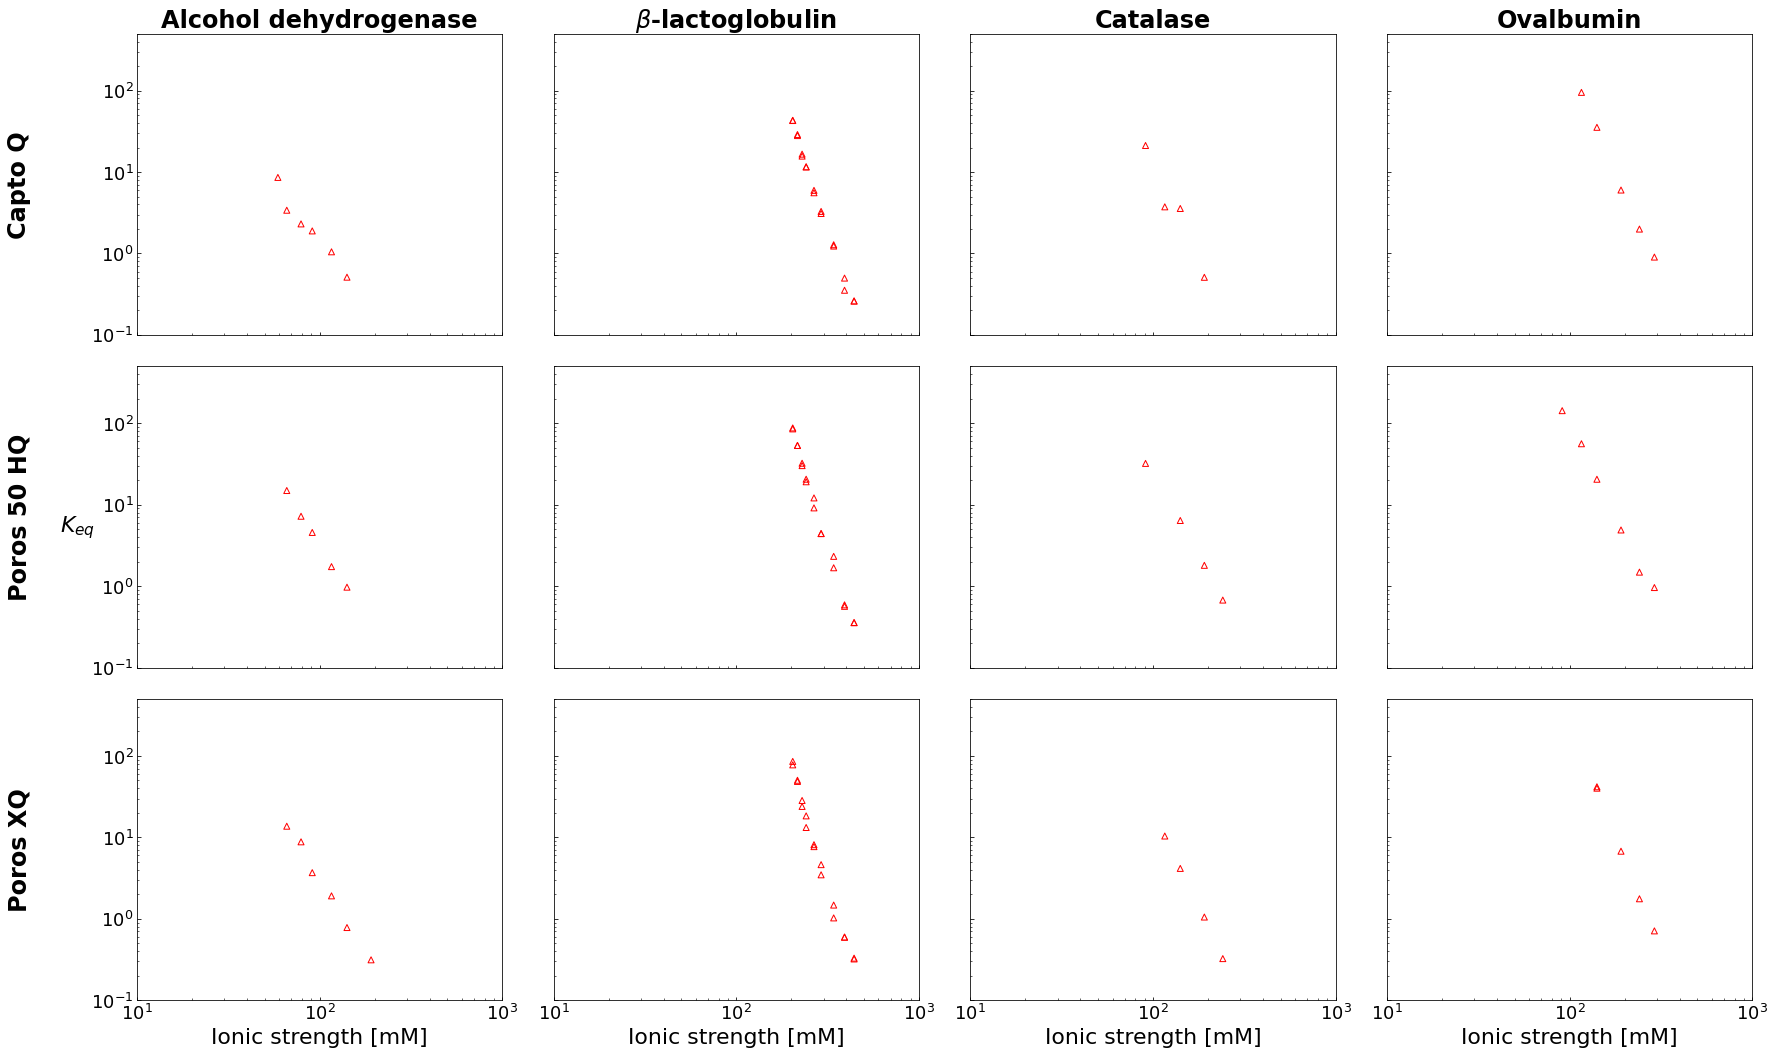

In [217]:
# Specify figure dimensions
title_size = 24 
label_size = 22
tick_label_size = 18

fig, ax = plt.subplots(len(resins), len(proteins), sharex=True, sharey=True)
font = {'weight' : 'normal', 'size'   : tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(25, 15, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.10)

# Add labels - note I'm hacking the y_label pad to conveniently get what I want
for n_pro, pro in enumerate(proteins):
    for n_res, res in enumerate(resins):
        ax[n_res, n_pro].tick_params(direction='in', which='both')
        ax[n_res, n_pro].set_xlabel('Ionic strength [mM]', fontsize=label_size)
        ax[n_res, n_pro].set_ylabel(resin_name[res], fontsize=title_size, fontweight='bold', labelpad=60)
        ax[n_res, n_pro].label_outer()
for n_pro, pro in enumerate(proteins):
    ax[0, n_pro].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')       
fig.text(0.04, 0.5, '$K_{eq}$', va='center', rotation=0, fontsize=label_size)

# Add the data
for f in files:
    data = data_files[f]
    if data.nacl < 900 and f not in exclude_files:
        n_pro = potein_number[data.protein]
        n_res = resin_number[data.resin]
        ax[n_res, n_pro].scatter(data.ion_str, data.keq, marker='^', facecolors='none', edgecolors='red')
        
# Set axis scales
ax[0, 0].set_ylim(0.1, 500)
ax[0, 0].set_xlim(10, 1000)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')

# Format and save the figure
my_plot.set_layout(fig) # Works in conjunction with the y_label pad hack above
fig.savefig('./images/Keq_cherry_picked.png', dpi=300)

# Direct comparison of $k'$ and $K_{eq}$



In [225]:
# Color and symbol maps
colors =\
{'caq':'black',
 'phq':'red',
 'pxq':'blue'
}

markers =\
{'caq':'o',
 'phq':'^',
 'pxq':'s'
}

# Location number maps
loc_number =\
{'adh':(0, 0),
 'blg':(0, 1),
 'cat':(1, 0),
 'ova':(1, 1)
}

# Function to not show replicate legend entries
def legend_without_duplicate_labels(ax, loc='best', handlelength=0.5):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc=loc, handlelength=handlelength, frameon=False)

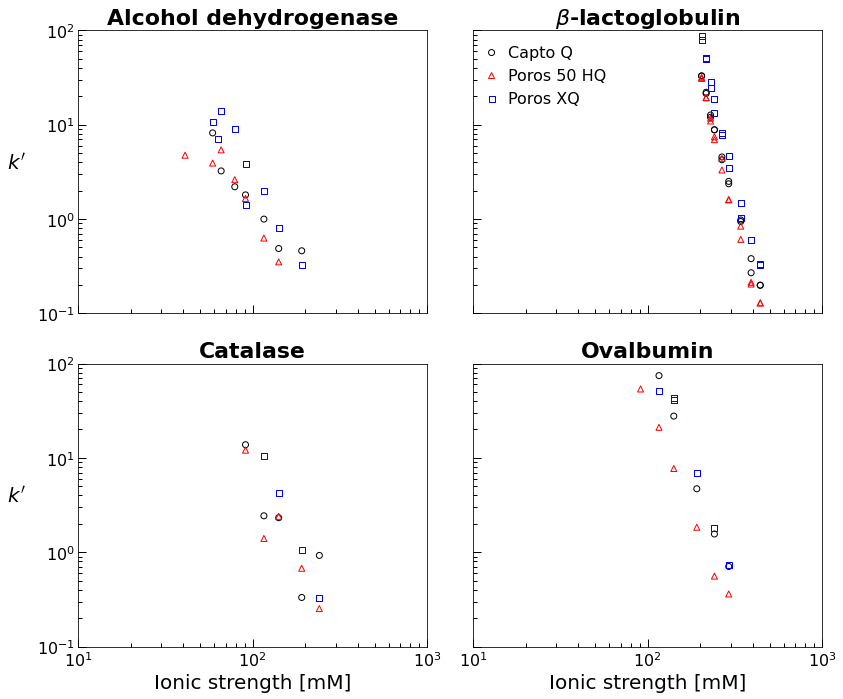

In [226]:
# Specify figure dimensions
title_size = 22 
label_size = 20
tick_label_size = 16

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
font = {'weight': 'normal', 'size': tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(12, 10, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.20)

# Add labels
for pro in proteins:
    n_row, n_col = loc_number[pro]
    ax[n_row, n_col].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')
    ax[n_row, n_col].set_xlabel('Ionic strength [mM]', fontsize=label_size)
    ax[n_row, n_col].set_ylabel('$k\'$', fontsize=label_size, rotation=0, labelpad=20)
    ax[n_row, n_col].label_outer()   
    ax[n_row, n_col].tick_params(axis='both', which='major', length=8, width=1, direction='in')
    ax[n_row, n_col].tick_params(axis='both', which='minor', length=4, width=1, direction='in')

# Add the data
for f in files:
    data = data_files[f]
    if data.nacl < 900:
        n_row, n_col = loc_number[data.protein]
        color  = colors[data.resin]
        marker = markers[data.resin]
        ax[n_row, n_col].scatter(data.ion_str, data.kprime, marker=marker, facecolors='none', 
                                 edgecolors=color, label=resin_name[data.resin])
        
# Add the legend
legend_without_duplicate_labels(ax[0, 1])

# Set axis scales
ax[0, 0].set_ylim(0.1, 100)
ax[0, 0].set_xlim(10, 1000)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')

# Format and save the figure
my_plot.set_layout(fig)
fig.savefig('./images/kprime_comparison_all.png', dpi=300)

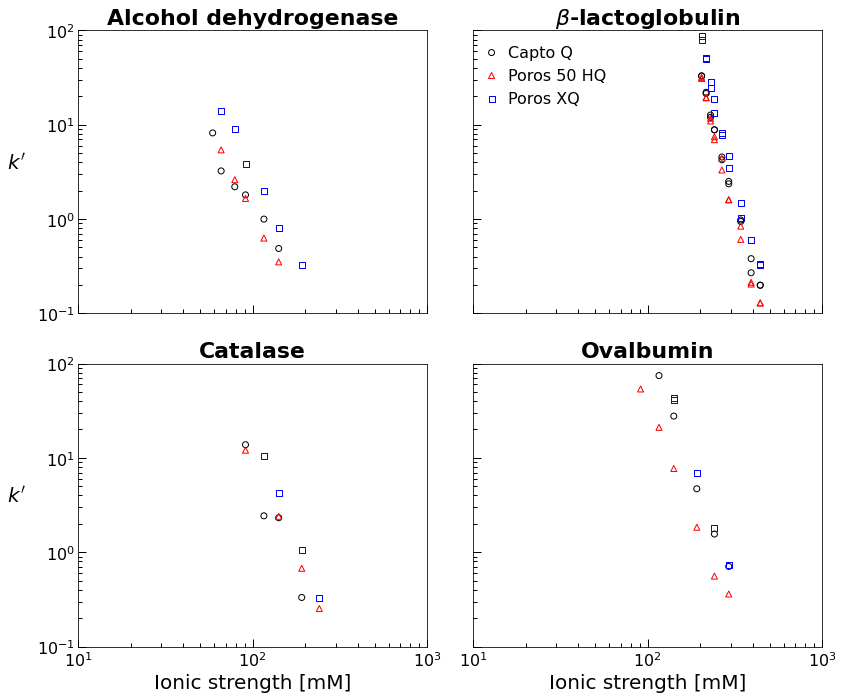

In [227]:
# Specify figure dimensions
title_size = 22 
label_size = 20
tick_label_size = 16

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
font = {'weight': 'normal', 'size': tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(12, 10, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.20)

# Add labels
for pro in proteins:
    n_row, n_col = loc_number[pro]
    ax[n_row, n_col].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')
    ax[n_row, n_col].set_xlabel('Ionic strength [mM]', fontsize=label_size)
    ax[n_row, n_col].set_ylabel('$k\'$', fontsize=label_size, rotation=0, labelpad=20)
    ax[n_row, n_col].label_outer()   
    ax[n_row, n_col].tick_params(axis='both', which='major', length=8, width=1, direction='in')
    ax[n_row, n_col].tick_params(axis='both', which='minor', length=4, width=1, direction='in')

# Add the data
for f in files:
    data = data_files[f]
    if data.nacl < 900 and f not in exclude_files:
        n_row, n_col = loc_number[data.protein]
        color  = colors[data.resin]
        marker = markers[data.resin]
        ax[n_row, n_col].scatter(data.ion_str, data.kprime, marker=marker, facecolors='none', 
                                 edgecolors=color, label=resin_name[data.resin])
        
# Add the legend
legend_without_duplicate_labels(ax[0, 1])

# Set axis scales
ax[0, 0].set_ylim(0.1, 100)
ax[0, 0].set_xlim(10, 1000)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')

# Format and save the figure
my_plot.set_layout(fig)
fig.savefig('./images/kprime_comparison_cherry_picked.png', dpi=300)

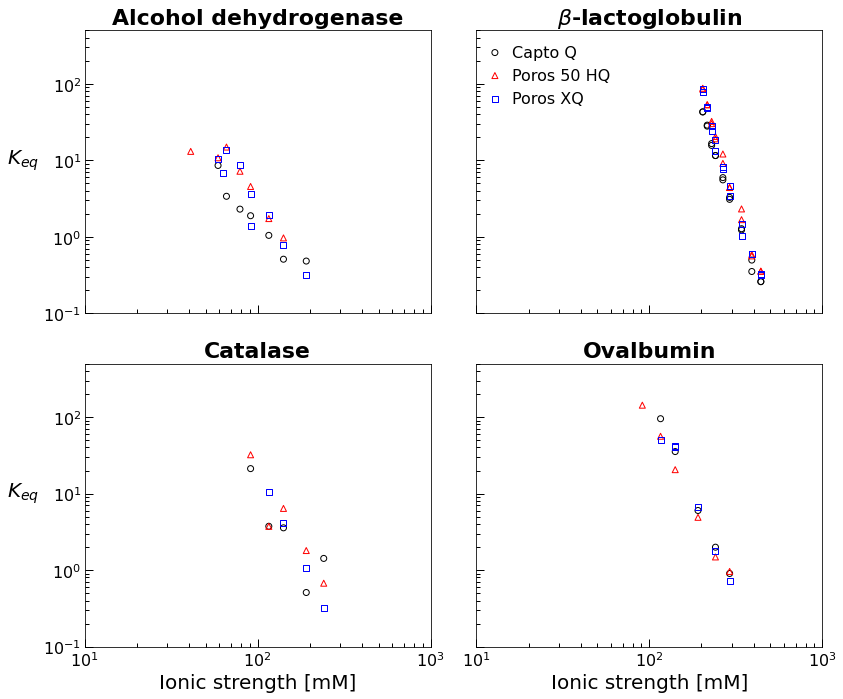

In [221]:
# Specify figure dimensions
title_size = 22 
label_size = 20
tick_label_size = 16

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
font = {'weight': 'normal', 'size': tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(12, 10, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.20)

# Add labels
for pro in proteins:
    n_row, n_col = loc_number[pro]
    ax[n_row, n_col].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')
    ax[n_row, n_col].set_xlabel('Ionic strength [mM]', fontsize=label_size)
    ax[n_row, n_col].set_ylabel('$K_{eq}$', fontsize=label_size, rotation=0, labelpad=20)
    ax[n_row, n_col].label_outer()   
    ax[n_row, n_col].tick_params(axis='both', which='major', length=8, width=1, direction='in')
    ax[n_row, n_col].tick_params(axis='both', which='minor', length=4, width=1, direction='in')

# Add the data
for f in files:
    data = data_files[f]
    if data.nacl < 900:
        n_row, n_col = loc_number[data.protein]
        color  = colors[data.resin]
        marker = markers[data.resin]
        ax[n_row, n_col].scatter(data.ion_str, data.keq, marker=marker, facecolors='none', 
                                 edgecolors=color, label=resin_name[data.resin])
        
# Add the legend
legend_without_duplicate_labels(ax[0, 1])

# Set axis scales
ax[0, 0].set_ylim(0.1, 500)
ax[0, 0].set_xlim(10, 1000)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')

# Format and save the figure
my_plot.set_layout(fig)
fig.savefig('./images/keq_comparison_all.png', dpi=300)

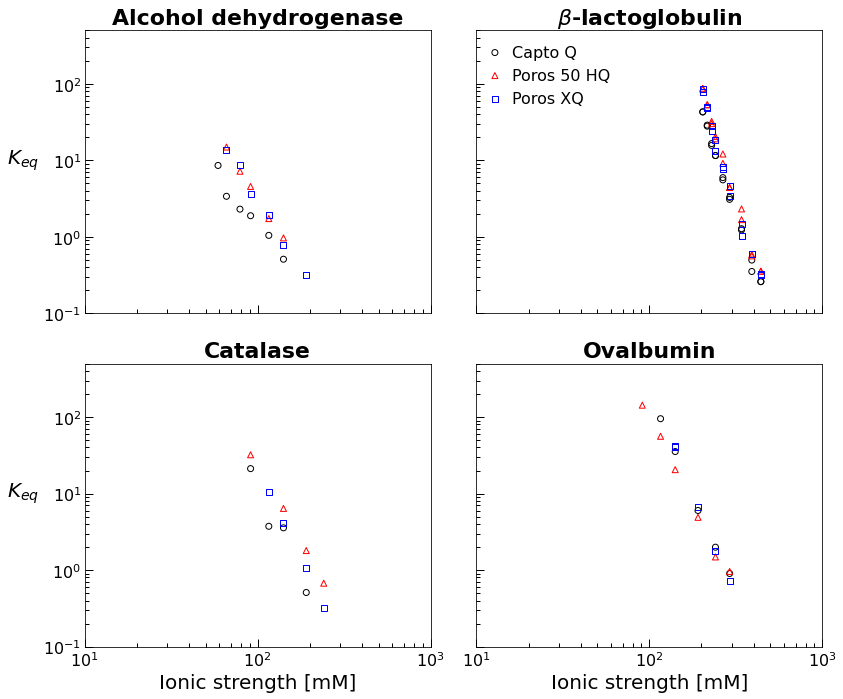

In [222]:
# Specify figure dimensions
title_size = 22 
label_size = 20
tick_label_size = 16

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
font = {'weight': 'normal', 'size': tick_label_size}
plt.rc('font', **font)
fig.set_size_inches(12, 10, forward=True)
matplotlib.pyplot.subplots_adjust(wspace=0.20)

# Add labels
for pro in proteins:
    n_row, n_col = loc_number[pro]
    ax[n_row, n_col].set_title(protein_name[pro], fontsize=title_size, fontweight='bold')
    ax[n_row, n_col].set_xlabel('Ionic strength [mM]', fontsize=label_size)
    ax[n_row, n_col].set_ylabel('$K_{eq}$', fontsize=label_size, rotation=0, labelpad=20)
    ax[n_row, n_col].label_outer()   
    ax[n_row, n_col].tick_params(axis='both', which='major', length=8, width=1, direction='in')
    ax[n_row, n_col].tick_params(axis='both', which='minor', length=4, width=1, direction='in')

# Add the data
for f in files:
    data = data_files[f]
    if data.nacl < 900 and f not in exclude_files:
        n_row, n_col = loc_number[data.protein]
        color  = colors[data.resin]
        marker = markers[data.resin]
        ax[n_row, n_col].scatter(data.ion_str, data.keq, marker=marker, facecolors='none', 
                                 edgecolors=color, label=resin_name[data.resin])
        
# Add the legend
legend_without_duplicate_labels(ax[0, 1])

# Set axis scales
ax[0, 0].set_ylim(0.1, 500)
ax[0, 0].set_xlim(10, 1000)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')

# Format and save the figure
my_plot.set_layout(fig)
fig.savefig('./images/keq_comparison_cherry_picked.png', dpi=300)

# Save $k'$ and $K_{eq}$ data

In [162]:
results = []

for f in files:
    data = data_files[f]
    if data.nacl < 900:
        if f in exclude_files:
            include = False
        else:
            include = True
        results.append([data.resin, data.protein, data.nacl, data.ion_str, data.replicate, data.cv_moment, data.eps_t, data.phi, data.kprime, data.keq, include])
        
df_results = pd.DataFrame(results, columns=['resin', 'protein', 'nacl_mM', 'ion_str_mM', 'replicate', 'cv_moment', 'eps_t', 'phi', 'kprime', 'keq', 'include'])
df_results.sort_values(by=['resin', 'protein', 'nacl_mM', 'replicate'], inplace=True, ignore_index=True)

In [164]:
# df_results.to_csv('./data/kprime_and_keq.csv', index=False)

In [171]:
df_results

resin protein  nacl_mM  ion_str_mM  replicate  cv_moment     eps_t  \
0     caq     adh     18.0        53.0          1   4.701250  0.511753   
1     caq     adh     25.0        60.0          1   2.168452  0.511753   
2     caq     adh     38.0        73.0          1   1.637124  0.511753   
3     caq     adh     50.0        85.0          1   1.435022  0.511753   
4     caq     adh     75.0       110.0          1   1.022967  0.511753   
..    ...     ...      ...         ...        ...        ...       ...   
105   pxq     ova    100.0       135.0          1  20.812132  0.494164   
106   pxq     ova    100.0       135.0          2  21.645350  0.494164   
107   pxq     ova    150.0       185.0          1   3.913191  0.494164   
108   pxq     ova    200.0       235.0          1   1.384622  0.494164   
109   pxq     ova    250.0       285.0          1   0.853314  0.494164   

          phi     kprime        keq  include  
0    0.954068   8.186562   8.580690     True  
1    0.954068   3.237303   3.393157     True  
2    0.954068   2.199052   2.304922     True  
3    0.954068   1.804130   1.890987     True  
4    0.954068   0.998947   1.047040     True  
..        ...        ...        ...      ...  
105  1.023620  41.115840  40.167106     True  
106  1.023620  42.801956  41.814316     True  
107  1.023620   6.918809   6.759160     True  
108  1.023620   1.801948   1.760369     True  
109  1.023620   0.726783   0.710013     True  

[110 rows x 11 columns]